In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperatures
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperatures
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperatures
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  temperatures          slp  vapor_pressure  \
0      2006-01-31     6501     12.209677  1018.534543        8.674922   
1      2006-02-28     6501      8.174541  1021.230347        6.942276   
2      2006-03-31     6501     15.676613  1018.968548       10.468176   
3      2006-04-30     6501     22.464167  1014.686944       16.358802   
4      2006-05-31     6501     23.657258  1014.236828       18.798749   
...           ...      ...           ...          ...             ...   
24057  2024-07-31     9858     28.604704  1013.969355       23.769169   
24058  2024-08-31     9858     29.114919  1015.112097       23.699154   
24059  2024-09-30     9858     24.570278  1014.393750       16.790240   
24060  2024-10-31     9858     21.159140  1018.230376       10.994776   
24061  2024-11-30     9858     12.112917  10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-19 17:11:13,709] A new study created in memory with name: no-name-09b7daa6-b090-4a5f-8916-1644b18f2af8
[I 2025-05-19 17:15:29,675] Trial 0 finished with value: 0.030324406921863556 and parameters: {'lr': 0.001008595108665685, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.39542314698111647}. Best is trial 0 with value: 0.030324406921863556.


Cross Validation Accuracies:
[0.0261495653539896, 0.02702201157808304, 0.030716167762875557, 0.04029197618365288, 0.027442313730716705]
Mean Cross Validation Accuracy:
0.030324406921863556
Standard Deviation of Cross Validation Accuracy:
0.005218189184593527


[I 2025-05-19 17:21:08,786] Trial 1 finished with value: 0.10514538288116455 and parameters: {'lr': 0.04785319893069401, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1035428596077634}. Best is trial 0 with value: 0.030324406921863556.


Cross Validation Accuracies:
[0.09802211076021194, 0.15700925886631012, 0.08462845534086227, 0.07926677912473679, 0.10680031031370163]
Mean Cross Validation Accuracy:
0.10514538288116455
Standard Deviation of Cross Validation Accuracy:
0.027691110020347232


[I 2025-05-19 17:28:59,868] Trial 2 finished with value: 0.04290972575545311 and parameters: {'lr': 0.05712114073859546, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.269500706711269}. Best is trial 0 with value: 0.030324406921863556.


Cross Validation Accuracies:
[0.0254052821546793, 0.02484443597495556, 0.06651123613119125, 0.05092798173427582, 0.04685969278216362]
Mean Cross Validation Accuracy:
0.04290972575545311
Standard Deviation of Cross Validation Accuracy:
0.01593540837943052


[I 2025-05-19 17:36:43,666] Trial 3 finished with value: 0.02821425534784794 and parameters: {'lr': 0.009964251005991529, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19403763316108683}. Best is trial 3 with value: 0.02821425534784794.


Cross Validation Accuracies:
[0.02417852357029915, 0.021806972101330757, 0.030064838007092476, 0.040064115077257156, 0.024956827983260155]
Mean Cross Validation Accuracy:
0.02821425534784794
Standard Deviation of Cross Validation Accuracy:
0.006508380357698113


[I 2025-05-19 17:42:12,614] Trial 4 finished with value: 0.04280352182686329 and parameters: {'lr': 0.07797494550210109, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.14126323697894044}. Best is trial 3 with value: 0.02821425534784794.


Cross Validation Accuracies:
[0.0458858385682106, 0.023674869909882545, 0.05561269447207451, 0.04238716885447502, 0.04645703732967377]
Mean Cross Validation Accuracy:
0.04280352182686329
Standard Deviation of Cross Validation Accuracy:
0.010516676564739655


[I 2025-05-19 17:48:26,024] Trial 5 finished with value: 0.053899826109409334 and parameters: {'lr': 0.10826454172937292, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11131760591332217}. Best is trial 3 with value: 0.02821425534784794.


Cross Validation Accuracies:
[0.05618384853005409, 0.04519180208444595, 0.050037261098623276, 0.05891672149300575, 0.05916949734091759]
Mean Cross Validation Accuracy:
0.053899826109409334
Standard Deviation of Cross Validation Accuracy:
0.005457188350754129


[I 2025-05-19 17:55:07,381] Trial 6 finished with value: 0.09529563784599304 and parameters: {'lr': 0.08994470307230629, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1811847075274732}. Best is trial 3 with value: 0.02821425534784794.


Cross Validation Accuracies:
[0.10041188448667526, 0.12058889120817184, 0.07570208609104156, 0.09205877035856247, 0.08771655708551407]
Mean Cross Validation Accuracy:
0.09529563784599304
Standard Deviation of Cross Validation Accuracy:
0.014951599860955825


[I 2025-05-19 18:02:12,608] Trial 7 finished with value: 0.03348378948867321 and parameters: {'lr': 0.0012269235636179672, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16183545419941298}. Best is trial 3 with value: 0.02821425534784794.


Cross Validation Accuracies:
[0.03219013288617134, 0.022288240492343903, 0.036419399082660675, 0.04963056743144989, 0.026890607550740242]
Mean Cross Validation Accuracy:
0.03348378948867321
Standard Deviation of Cross Validation Accuracy:
0.009378914163406584


[I 2025-05-19 18:08:48,810] Trial 8 finished with value: 3.804098653793335 and parameters: {'lr': 0.1613900248203082, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.35521835701332816}. Best is trial 3 with value: 0.02821425534784794.


Cross Validation Accuracies:
[2.750553846359253, 1.138134241104126, 4.1236491203308105, 8.717889785766602, 2.290266275405884]
Mean Cross Validation Accuracy:
3.804098653793335
Standard Deviation of Cross Validation Accuracy:
2.6365305676276267


[I 2025-05-19 18:15:03,624] Trial 9 finished with value: 0.035931070894002916 and parameters: {'lr': 0.027719144948849514, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.28570368668379964}. Best is trial 3 with value: 0.02821425534784794.


Cross Validation Accuracies:
[0.03485767915844917, 0.02217859774827957, 0.051514800637960434, 0.04289836436510086, 0.028205912560224533]
Mean Cross Validation Accuracy:
0.035931070894002916
Standard Deviation of Cross Validation Accuracy:
0.010405350256179297


[I 2025-05-19 18:21:59,383] Trial 10 finished with value: 0.027932533994317055 and parameters: {'lr': 0.008277782730389248, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2244268934371294}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.027939653024077415, 0.025440441444516182, 0.02838999778032303, 0.034179821610450745, 0.023712756112217903]
Mean Cross Validation Accuracy:
0.027932533994317055
Standard Deviation of Cross Validation Accuracy:
0.003556823779886072


[I 2025-05-19 18:29:36,528] Trial 11 finished with value: 0.028599345311522483 and parameters: {'lr': 0.006769002040543011, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.488460573093308}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.025649456307291985, 0.020802179351449013, 0.033299606293439865, 0.03891138359904289, 0.024334101006388664]
Mean Cross Validation Accuracy:
0.028599345311522483
Standard Deviation of Cross Validation Accuracy:
0.006574504362613302


[I 2025-05-19 18:37:35,174] Trial 12 finished with value: 0.3507675349712372 and parameters: {'lr': 0.6841070356313943, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22674721742992052}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.3458651900291443, 0.36215582489967346, 0.3513849973678589, 0.35038402676582336, 0.3440476357936859]
Mean Cross Validation Accuracy:
0.3507675349712372
Standard Deviation of Cross Validation Accuracy:
0.006315243728261052


[I 2025-05-19 18:45:47,227] Trial 13 finished with value: 0.031231313943862915 and parameters: {'lr': 0.008141006231433663, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22294655185918283}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.02375841699540615, 0.037499237805604935, 0.0359467975795269, 0.03445473313331604, 0.02449738420546055]
Mean Cross Validation Accuracy:
0.031231313943862915
Standard Deviation of Cross Validation Accuracy:
0.005883928708775093


[I 2025-05-19 18:52:46,211] Trial 14 finished with value: 0.13440444618463515 and parameters: {'lr': 0.006911588686104342, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21726836485117962}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.12402668595314026, 0.1525493860244751, 0.12544038891792297, 0.14582619071006775, 0.12417957931756973]
Mean Cross Validation Accuracy:
0.13440444618463515
Standard Deviation of Cross Validation Accuracy:
0.012266174810006296


[I 2025-05-19 19:00:13,447] Trial 15 finished with value: 0.030239278823137282 and parameters: {'lr': 0.018655129182488024, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3063447855810018}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.02475232630968094, 0.021578071638941765, 0.04279981926083565, 0.03638406842947006, 0.025682108476758003]
Mean Cross Validation Accuracy:
0.030239278823137282
Standard Deviation of Cross Validation Accuracy:
0.008017687630876558


[I 2025-05-19 19:06:10,839] Trial 16 finished with value: 0.033819610998034474 and parameters: {'lr': 0.0029609847466233034, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.34022297930065576}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.02842581272125244, 0.032780684530735016, 0.03825932741165161, 0.041896965354681015, 0.027735264971852303]
Mean Cross Validation Accuracy:
0.033819610998034474
Standard Deviation of Cross Validation Accuracy:
0.005516274646127932


[I 2025-05-19 19:13:26,768] Trial 17 finished with value: 0.028120894357562064 and parameters: {'lr': 0.013515766849618938, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17995028413702482}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.024566560983657837, 0.02485092356801033, 0.028089558705687523, 0.037739098072052, 0.025358330458402634]
Mean Cross Validation Accuracy:
0.028120894357562064
Standard Deviation of Cross Validation Accuracy:
0.004969277183068306


[I 2025-05-19 19:20:31,999] Trial 18 finished with value: 0.029078015685081483 and parameters: {'lr': 0.0036772110582563096, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2594072767979287}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.025643952190876007, 0.02572769671678543, 0.028819607570767403, 0.0369916707277298, 0.02820715121924877]
Mean Cross Validation Accuracy:
0.029078015685081483
Standard Deviation of Cross Validation Accuracy:
0.0041585705495274594


[I 2025-05-19 19:27:39,743] Trial 19 finished with value: 3.8498446106910706 and parameters: {'lr': 0.3936963433675074, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.45124590689698996}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[9.54840087890625, 3.0611765384674072, 0.7343106865882874, 5.270069122314453, 0.6352658271789551]
Mean Cross Validation Accuracy:
3.8498446106910706
Standard Deviation of Cross Validation Accuracy:
3.3212240791978163


[I 2025-05-19 19:34:49,781] Trial 20 finished with value: 0.04276207350194454 and parameters: {'lr': 0.01824782215669128, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14622390573205646}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.043153002858161926, 0.023232759907841682, 0.05413561686873436, 0.03740411624312401, 0.05588487163186073]
Mean Cross Validation Accuracy:
0.04276207350194454
Standard Deviation of Cross Validation Accuracy:
0.011931638116205933


[I 2025-05-19 19:40:48,113] Trial 21 finished with value: 0.028431764617562295 and parameters: {'lr': 0.013766419140194532, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19485192209883753}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.025723736733198166, 0.023847509175539017, 0.028597313910722733, 0.03778421878814697, 0.026206044480204582]
Mean Cross Validation Accuracy:
0.028431764617562295
Standard Deviation of Cross Validation Accuracy:
0.004915250729950731


[I 2025-05-19 19:47:54,402] Trial 22 finished with value: 0.029877401888370514 and parameters: {'lr': 0.00349009999211059, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2421614389030851}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.02553650550544262, 0.023834580555558205, 0.03288762643933296, 0.039870236068964005, 0.02725806087255478]
Mean Cross Validation Accuracy:
0.029877401888370514
Standard Deviation of Cross Validation Accuracy:
0.0058504393891877435


[I 2025-05-19 19:56:01,010] Trial 23 finished with value: 0.031205203756690024 and parameters: {'lr': 0.0104268378145718, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.19276237454350603}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.02476685680449009, 0.029571764171123505, 0.0331716351211071, 0.04227759689092636, 0.02623816579580307]
Mean Cross Validation Accuracy:
0.031205203756690024
Standard Deviation of Cross Validation Accuracy:
0.0062491062479611776


[I 2025-05-19 20:02:50,244] Trial 24 finished with value: 0.039179443195462224 and parameters: {'lr': 0.03562036216706341, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.31122358437313913}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.026750473305583, 0.0428171381354332, 0.05291024222970009, 0.04761175066232681, 0.025807611644268036]
Mean Cross Validation Accuracy:
0.039179443195462224
Standard Deviation of Cross Validation Accuracy:
0.011010509955199123


[I 2025-05-19 20:10:35,037] Trial 25 finished with value: 0.030597073212265968 and parameters: {'lr': 0.0017425240393066153, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1606032296054141}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.0257619209587574, 0.025046251714229584, 0.03367277607321739, 0.04100499302148819, 0.027499424293637276]
Mean Cross Validation Accuracy:
0.030597073212265968
Standard Deviation of Cross Validation Accuracy:
0.006026117959098021


[I 2025-05-19 20:15:46,962] Trial 26 finished with value: 0.029875270649790765 and parameters: {'lr': 0.0048185177805834395, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.20169290116462488}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.024608833715319633, 0.023915685713291168, 0.029911862686276436, 0.04022492840886116, 0.03071504272520542]
Mean Cross Validation Accuracy:
0.029875270649790765
Standard Deviation of Cross Validation Accuracy:
0.005849341543212895


[I 2025-05-19 20:23:12,199] Trial 27 finished with value: 0.029653901979327203 and parameters: {'lr': 0.02529754986504994, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2525964884918019}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.031466808170080185, 0.024612369015812874, 0.027705149725079536, 0.036633748561143875, 0.02785143442451954]
Mean Cross Validation Accuracy:
0.029653901979327203
Standard Deviation of Cross Validation Accuracy:
0.0041101938255741575


[I 2025-05-19 20:30:42,046] Trial 28 finished with value: 0.04021564871072769 and parameters: {'lr': 0.012057436514768805, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11983314296977737}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.027661584317684174, 0.03740399703383446, 0.036385782063007355, 0.0609872005879879, 0.03863967955112457]
Mean Cross Validation Accuracy:
0.04021564871072769
Standard Deviation of Cross Validation Accuracy:
0.011082588530284002


[I 2025-05-19 20:36:17,041] Trial 29 finished with value: 0.031773396953940394 and parameters: {'lr': 0.00172599038892591, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.17274092685015932}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.02542096935212612, 0.025463087484240532, 0.03533142805099487, 0.04418705031275749, 0.02846444956958294]
Mean Cross Validation Accuracy:
0.031773396953940394
Standard Deviation of Cross Validation Accuracy:
0.0071816550993848115


[I 2025-05-19 20:41:55,870] Trial 30 finished with value: 0.029358813911676405 and parameters: {'lr': 0.005297382462749546, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.38453453218944783}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.02575111575424671, 0.025982117280364037, 0.030460791662335396, 0.037932731211185455, 0.026667313650250435]
Mean Cross Validation Accuracy:
0.029358813911676405
Standard Deviation of Cross Validation Accuracy:
0.004612768206057226


[I 2025-05-19 20:48:38,669] Trial 31 finished with value: 0.030446581542491913 and parameters: {'lr': 0.015066840324091939, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.213316452571198}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.02473914623260498, 0.02617708407342434, 0.035194993019104004, 0.03794769570231438, 0.028173988685011864]
Mean Cross Validation Accuracy:
0.030446581542491913
Standard Deviation of Cross Validation Accuracy:
0.005191959744464481


[I 2025-05-19 20:56:05,722] Trial 32 finished with value: 0.029886075481772422 and parameters: {'lr': 0.010086784510828619, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.18686052186992902}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.026119856163859367, 0.02794131450355053, 0.03163226693868637, 0.038861315697431564, 0.024875624105334282]
Mean Cross Validation Accuracy:
0.029886075481772422
Standard Deviation of Cross Validation Accuracy:
0.005033393442632343


[I 2025-05-19 21:03:46,113] Trial 33 finished with value: 0.03274423666298389 and parameters: {'lr': 0.02168378250002534, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13750909622495328}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.03128806874155998, 0.02181810885667801, 0.034411340951919556, 0.04682052507996559, 0.029383139684796333]
Mean Cross Validation Accuracy:
0.03274423666298389
Standard Deviation of Cross Validation Accuracy:
0.008169685416956236


[I 2025-05-19 21:10:29,109] Trial 34 finished with value: 0.03018924593925476 and parameters: {'lr': 0.015048128199324528, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.24165098159764076}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.025043489411473274, 0.026817305013537407, 0.03302692621946335, 0.039727017283439636, 0.026331491768360138]
Mean Cross Validation Accuracy:
0.03018924593925476
Standard Deviation of Cross Validation Accuracy:
0.005509130143306239


[I 2025-05-19 21:16:43,609] Trial 35 finished with value: 0.03247199989855289 and parameters: {'lr': 0.05839621051798325, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2816992409584299}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.02649683505296707, 0.02598458342254162, 0.03547319024801254, 0.0397440604865551, 0.03466133028268814]
Mean Cross Validation Accuracy:
0.03247199989855289
Standard Deviation of Cross Validation Accuracy:
0.005375357545416113


[I 2025-05-19 21:22:38,537] Trial 36 finished with value: 0.03623359836637974 and parameters: {'lr': 0.04151721516505108, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.12671774915901202}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.024835310876369476, 0.030309630557894707, 0.03681808337569237, 0.04276546463370323, 0.04643950238823891]
Mean Cross Validation Accuracy:
0.03623359836637974
Standard Deviation of Cross Validation Accuracy:
0.00790166727804458


[I 2025-05-19 21:32:23,857] Trial 37 finished with value: 0.17034209221601487 and parameters: {'lr': 0.005495337063879615, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.15712799870772567}. Best is trial 10 with value: 0.027932533994317055.


Cross Validation Accuracies:
[0.16654442250728607, 0.19692657887935638, 0.17546594142913818, 0.18809626996517181, 0.12467724829912186]
Mean Cross Validation Accuracy:
0.17034209221601487
Standard Deviation of Cross Validation Accuracy:
0.025091432221504072


[I 2025-05-19 21:39:30,040] Trial 38 finished with value: 0.019865182973444463 and parameters: {'lr': 0.0027839050911549826, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10565454968952964}. Best is trial 38 with value: 0.019865182973444463.


Cross Validation Accuracies:
[0.017369262874126434, 0.03280650079250336, 0.018460795283317566, 0.015189135447144508, 0.015500220470130444]
Mean Cross Validation Accuracy:
0.019865182973444463
Standard Deviation of Cross Validation Accuracy:
0.006581761875726047


[I 2025-05-19 21:47:00,560] Trial 39 finished with value: 0.018280835077166557 and parameters: {'lr': 0.0023086712816196187, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10735681181636805}. Best is trial 39 with value: 0.018280835077166557.


Cross Validation Accuracies:
[0.016483210027217865, 0.018602849915623665, 0.025566227734088898, 0.01639563776552677, 0.014356249943375587]
Mean Cross Validation Accuracy:
0.018280835077166557
Standard Deviation of Cross Validation Accuracy:
0.003882484588974295


[I 2025-05-19 21:54:56,795] Trial 40 finished with value: 0.01810722816735506 and parameters: {'lr': 0.0023754652438652923, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10158338120775418}. Best is trial 40 with value: 0.01810722816735506.


Cross Validation Accuracies:
[0.016301462426781654, 0.019263405352830887, 0.021693695336580276, 0.017991632223129272, 0.015285945497453213]
Mean Cross Validation Accuracy:
0.01810722816735506
Standard Deviation of Cross Validation Accuracy:
0.0022553616417676217


[I 2025-05-19 22:02:28,331] Trial 41 finished with value: 0.0311677198857069 and parameters: {'lr': 0.002445176874145528, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10415077485186969}. Best is trial 40 with value: 0.01810722816735506.


Cross Validation Accuracies:
[0.04433568939566612, 0.017378494143486023, 0.025001563131809235, 0.028418870642781258, 0.04070398211479187]
Mean Cross Validation Accuracy:
0.0311677198857069
Standard Deviation of Cross Validation Accuracy:
0.010000561245860014


[I 2025-05-19 22:07:30,911] Trial 42 finished with value: 0.02109471205621958 and parameters: {'lr': 0.0019494005162485385, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12112127268156066}. Best is trial 40 with value: 0.01810722816735506.


Cross Validation Accuracies:
[0.02281520515680313, 0.02548118680715561, 0.0223810113966465, 0.020863384008407593, 0.013932772912085056]
Mean Cross Validation Accuracy:
0.02109471205621958
Standard Deviation of Cross Validation Accuracy:
0.0038782137180131907


[I 2025-05-19 22:12:28,791] Trial 43 finished with value: 0.02338887955993414 and parameters: {'lr': 0.0012766396618389597, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10009738278507578}. Best is trial 40 with value: 0.01810722816735506.


Cross Validation Accuracies:
[0.029270507395267487, 0.03220679238438606, 0.015074045397341251, 0.018349697813391685, 0.02204335480928421]
Mean Cross Validation Accuracy:
0.02338887955993414
Standard Deviation of Cross Validation Accuracy:
0.006460485883487738


[I 2025-05-19 22:17:28,363] Trial 44 finished with value: 0.017415125854313374 and parameters: {'lr': 0.0010051824349818898, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10355392801902838}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02023390121757984, 0.01987597718834877, 0.015523449517786503, 0.01630665920674801, 0.015135642141103745]
Mean Cross Validation Accuracy:
0.017415125854313374
Standard Deviation of Cross Validation Accuracy:
0.002191094133373109


[I 2025-05-19 22:22:45,568] Trial 45 finished with value: 0.021544748917222023 and parameters: {'lr': 0.00102346742200907, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13406304145342493}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.020450409501791, 0.018791038542985916, 0.024122895672917366, 0.01724446751177311, 0.027114933356642723]
Mean Cross Validation Accuracy:
0.021544748917222023
Standard Deviation of Cross Validation Accuracy:
0.00360407311608569


[I 2025-05-19 22:29:16,914] Trial 46 finished with value: 0.021038514003157614 and parameters: {'lr': 0.0019839132550103526, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1164893420733369}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02491319365799427, 0.021848371252417564, 0.02018389105796814, 0.021519262343645096, 0.016727851703763008]
Mean Cross Validation Accuracy:
0.021038514003157614
Standard Deviation of Cross Validation Accuracy:
0.0026537641190027346


[I 2025-05-19 22:34:22,008] Trial 47 finished with value: 0.026510564237833024 and parameters: {'lr': 0.002270730809471249, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10134239687982385}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.021347906440496445, 0.019106270745396614, 0.017745723947882652, 0.021660324186086655, 0.05269259586930275]
Mean Cross Validation Accuracy:
0.026510564237833024
Standard Deviation of Cross Validation Accuracy:
0.013170593243083012


[I 2025-05-19 22:39:59,119] Trial 48 finished with value: 0.02541077435016632 and parameters: {'lr': 0.0013643493868725283, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15149416916627836}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.024061135947704315, 0.04109707847237587, 0.023501409217715263, 0.020165519788861275, 0.01822872832417488]
Mean Cross Validation Accuracy:
0.02541077435016632
Standard Deviation of Cross Validation Accuracy:
0.008131688835330816


[I 2025-05-19 22:46:04,880] Trial 49 finished with value: 0.025071350485086442 and parameters: {'lr': 0.002709932872562454, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11717404994165039}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.03446267545223236, 0.018144264817237854, 0.035015009343624115, 0.020109983161091805, 0.01762481965124607]
Mean Cross Validation Accuracy:
0.025071350485086442
Standard Deviation of Cross Validation Accuracy:
0.00793881400671616


[I 2025-05-19 22:52:56,547] Trial 50 finished with value: 0.02402861788868904 and parameters: {'lr': 0.003960887814864997, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13625184823620523}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.017513463273644447, 0.02358020655810833, 0.021930526942014694, 0.027550488710403442, 0.029568403959274292]
Mean Cross Validation Accuracy:
0.02402861788868904
Standard Deviation of Cross Validation Accuracy:
0.004246012289019912


[I 2025-05-19 22:58:44,410] Trial 51 finished with value: 0.022015880048274993 and parameters: {'lr': 0.0018360992942880543, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.119422788032095}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.020618267357349396, 0.019848698750138283, 0.025416674092411995, 0.023108286783099174, 0.02108747325837612]
Mean Cross Validation Accuracy:
0.022015880048274993
Standard Deviation of Cross Validation Accuracy:
0.0020134889016474398


[I 2025-05-19 23:04:41,362] Trial 52 finished with value: 0.02519346810877323 and parameters: {'lr': 0.0019895698445740535, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11924653207051812}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02327747829258442, 0.0186394564807415, 0.03542131558060646, 0.03204495087265968, 0.016584139317274094]
Mean Cross Validation Accuracy:
0.02519346810877323
Standard Deviation of Cross Validation Accuracy:
0.007379678957883857


[I 2025-05-19 23:10:47,205] Trial 53 finished with value: 0.017968975007534027 and parameters: {'lr': 0.0014170552376221652, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14055992970260342}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.019925260916352272, 0.016803594306111336, 0.01740129105746746, 0.018529793247580528, 0.01718493551015854]
Mean Cross Validation Accuracy:
0.017968975007534027
Standard Deviation of Cross Validation Accuracy:
0.0011346071421656145


[I 2025-05-19 23:16:43,927] Trial 54 finished with value: 0.0239667858928442 and parameters: {'lr': 0.0010051626322476821, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16791483655006711}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.019311940297484398, 0.024081967771053314, 0.02013961412012577, 0.016485033556818962, 0.039815373718738556]
Mean Cross Validation Accuracy:
0.0239667858928442
Standard Deviation of Cross Validation Accuracy:
0.008288334600537154


[I 2025-05-19 23:22:39,676] Trial 55 finished with value: 0.042517725750803946 and parameters: {'lr': 0.0014055765389590581, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15232951047136536}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.05179354175925255, 0.022694073617458344, 0.029736841097474098, 0.07462115585803986, 0.03374301642179489]
Mean Cross Validation Accuracy:
0.042517725750803946
Standard Deviation of Cross Validation Accuracy:
0.01870825864428323


[I 2025-05-19 23:28:23,898] Trial 56 finished with value: 0.030050106532871722 and parameters: {'lr': 0.0031024457985685144, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13930427584847882}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.019813524559140205, 0.04938004910945892, 0.024008028209209442, 0.041895538568496704, 0.015153392218053341]
Mean Cross Validation Accuracy:
0.030050106532871722
Standard Deviation of Cross Validation Accuracy:
0.013245130112432106


[I 2025-05-19 23:33:24,650] Trial 57 finished with value: 0.022634394466876984 and parameters: {'lr': 0.0015138160289577124, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10891621358347699}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.01725710742175579, 0.01693054288625717, 0.0303536057472229, 0.032744910567998886, 0.01588580571115017]
Mean Cross Validation Accuracy:
0.022634394466876984
Standard Deviation of Cross Validation Accuracy:
0.007332139491784845


[I 2025-05-19 23:39:05,180] Trial 58 finished with value: 0.03252246528863907 and parameters: {'lr': 0.14977646120734264, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10070076425191068}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02683413214981556, 0.029625605791807175, 0.030176805332303047, 0.04650384187698364, 0.02947194129228592]
Mean Cross Validation Accuracy:
0.03252246528863907
Standard Deviation of Cross Validation Accuracy:
0.007085698800129982


[I 2025-05-19 23:44:23,289] Trial 59 finished with value: 0.020270545780658723 and parameters: {'lr': 0.00415867110621609, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1343005003641327}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02479502744972706, 0.01951083540916443, 0.020976047962903976, 0.01894902065396309, 0.017121797427535057]
Mean Cross Validation Accuracy:
0.020270545780658723
Standard Deviation of Cross Validation Accuracy:
0.0025770864325137064


[I 2025-05-19 23:50:21,154] Trial 60 finished with value: 0.021784724295139314 and parameters: {'lr': 0.004170799921735279, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14382934754305093}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.015759332105517387, 0.03160817548632622, 0.020157935097813606, 0.020683595910668373, 0.02071458287537098]
Mean Cross Validation Accuracy:
0.021784724295139314
Standard Deviation of Cross Validation Accuracy:
0.005249946167615727


[I 2025-05-19 23:55:19,961] Trial 61 finished with value: 0.020172794908285142 and parameters: {'lr': 0.002548139008274911, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12948632231739926}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02095169760286808, 0.025135444477200508, 0.01877976581454277, 0.02031560055911541, 0.015681466087698936]
Mean Cross Validation Accuracy:
0.020172794908285142
Standard Deviation of Cross Validation Accuracy:
0.0030779063740157676


[I 2025-05-20 00:00:35,347] Trial 62 finished with value: 0.023033077642321587 and parameters: {'lr': 0.0028405384364941955, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1300393002038086}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.028984736651182175, 0.031239422038197517, 0.02147492952644825, 0.019045287743210793, 0.014421012252569199]
Mean Cross Validation Accuracy:
0.023033077642321587
Standard Deviation of Cross Validation Accuracy:
0.006249228710957799


[I 2025-05-20 00:05:38,126] Trial 63 finished with value: 0.03539169691503048 and parameters: {'lr': 0.00678530978598019, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17169363624923842}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.026011614128947258, 0.02630453184247017, 0.049270667135715485, 0.04079817235469818, 0.034573499113321304]
Mean Cross Validation Accuracy:
0.03539169691503048
Standard Deviation of Cross Validation Accuracy:
0.008866653944288655


[I 2025-05-20 00:10:27,419] Trial 64 finished with value: 0.022774803265929223 and parameters: {'lr': 0.002468521453659819, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15137531192936346}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02930593304336071, 0.017716793343424797, 0.02674863301217556, 0.017984412610530853, 0.02211824432015419]
Mean Cross Validation Accuracy:
0.022774803265929223
Standard Deviation of Cross Validation Accuracy:
0.004634853949771513


[I 2025-05-20 00:16:16,691] Trial 65 finished with value: 0.037569713592529294 and parameters: {'lr': 0.0011221813321534394, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12795000026298964}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.05216885730624199, 0.031751908361911774, 0.03458056226372719, 0.041414108127355576, 0.027933131903409958]
Mean Cross Validation Accuracy:
0.037569713592529294
Standard Deviation of Cross Validation Accuracy:
0.008527132654438878


[I 2025-05-20 00:21:50,864] Trial 66 finished with value: 0.03395415432751179 and parameters: {'lr': 0.0034369677442730824, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4642522054040929}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.025411255657672882, 0.029250090941786766, 0.03079809993505478, 0.044887691736221313, 0.039423633366823196]
Mean Cross Validation Accuracy:
0.03395415432751179
Standard Deviation of Cross Validation Accuracy:
0.007134808344690399


[I 2025-05-20 00:26:13,523] Trial 67 finished with value: 0.0464141096919775 and parameters: {'lr': 0.0016446724496486556, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11305990396275066}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.03721078857779503, 0.05317263305187225, 0.056056562811136246, 0.05573788657784462, 0.029892677441239357]
Mean Cross Validation Accuracy:
0.0464141096919775
Standard Deviation of Cross Validation Accuracy:
0.010800427757504186


[I 2025-05-20 00:29:41,462] Trial 68 finished with value: 0.03340657539665699 and parameters: {'lr': 0.004599768054798356, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.18044694085769897}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.030043454840779305, 0.030259056016802788, 0.04199102520942688, 0.042980194091796875, 0.021759146824479103]
Mean Cross Validation Accuracy:
0.03340657539665699
Standard Deviation of Cross Validation Accuracy:
0.008027789284377206


[I 2025-05-20 00:33:45,086] Trial 69 finished with value: 0.024573519453406335 and parameters: {'lr': 0.0023088392721125326, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16386487849780917}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02824261225759983, 0.03227797895669937, 0.021452646702528, 0.020301274955272675, 0.020593084394931793]
Mean Cross Validation Accuracy:
0.024573519453406335
Standard Deviation of Cross Validation Accuracy:
0.004830253021890434


[I 2025-05-20 00:37:46,927] Trial 70 finished with value: 0.023479393124580382 and parameters: {'lr': 0.0015219937200503923, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1443655868926003}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.03472594916820526, 0.02113061584532261, 0.01669783890247345, 0.020549949258565903, 0.024292612448334694]
Mean Cross Validation Accuracy:
0.023479393124580382
Standard Deviation of Cross Validation Accuracy:
0.006119382685369276


[I 2025-05-20 00:41:56,564] Trial 71 finished with value: 0.01933700107038021 and parameters: {'lr': 0.002070983704627586, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1165025146780402}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.017025306820869446, 0.01941729709506035, 0.021539172157645226, 0.023943495005369186, 0.014759734272956848]
Mean Cross Validation Accuracy:
0.01933700107038021
Standard Deviation of Cross Validation Accuracy:
0.0032363897466241944


[I 2025-05-20 00:46:02,517] Trial 72 finished with value: 0.020075269788503648 and parameters: {'lr': 0.0012448516593818642, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10917637804643703}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.022089829668402672, 0.023107357323169708, 0.016065163537859917, 0.018306860700249672, 0.020807137712836266]
Mean Cross Validation Accuracy:
0.020075269788503648
Standard Deviation of Cross Validation Accuracy:
0.002568885354822756


[I 2025-05-20 00:49:49,631] Trial 73 finished with value: 0.0202109269797802 and parameters: {'lr': 0.0011633475446639104, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10883843887415867}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.017762135714292526, 0.017085913568735123, 0.01863044500350952, 0.027237696573138237, 0.02033844403922558]
Mean Cross Validation Accuracy:
0.0202109269797802
Standard Deviation of Cross Validation Accuracy:
0.0036783681783379824


[I 2025-05-20 00:53:51,676] Trial 74 finished with value: 0.028250423446297645 and parameters: {'lr': 0.0030990911482194784, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12682244960073297}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.03233805671334267, 0.030638152733445168, 0.03282099589705467, 0.01826244406402111, 0.02719246782362461]
Mean Cross Validation Accuracy:
0.028250423446297645
Standard Deviation of Cross Validation Accuracy:
0.005369900029656063


[I 2025-05-20 00:58:18,777] Trial 75 finished with value: 0.036322638392448425 and parameters: {'lr': 0.001277633186774097, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11156047135665506}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.05346902832388878, 0.022313186898827553, 0.031555335968732834, 0.047538723796606064, 0.026736916974186897]
Mean Cross Validation Accuracy:
0.036322638392448425
Standard Deviation of Cross Validation Accuracy:
0.012088649371490229


[I 2025-05-20 01:03:20,735] Trial 76 finished with value: 0.03701156266033649 and parameters: {'lr': 0.00580510727497151, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12656813604721215}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02548464946448803, 0.054154884070158005, 0.03615940734744072, 0.040712468326091766, 0.028546404093503952]
Mean Cross Validation Accuracy:
0.03701156266033649
Standard Deviation of Cross Validation Accuracy:
0.01012763523998376


[I 2025-05-20 01:06:24,532] Trial 77 finished with value: 0.04462929517030716 and parameters: {'lr': 0.0021380793919176496, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.10004862952925007}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.03128654137253761, 0.07706955075263977, 0.035234685987234116, 0.04064536094665527, 0.038910336792469025]
Mean Cross Validation Accuracy:
0.04462929517030716
Standard Deviation of Cross Validation Accuracy:
0.016536239957641315


[I 2025-05-20 01:10:05,417] Trial 78 finished with value: 0.019974950328469278 and parameters: {'lr': 0.0017247992492221184, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20373365224868734}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.027439765632152557, 0.018266191706061363, 0.018664473667740822, 0.01721026748418808, 0.01829405315220356]
Mean Cross Validation Accuracy:
0.019974950328469278
Standard Deviation of Cross Validation Accuracy:
0.003763762988624877


[I 2025-05-20 01:13:49,891] Trial 79 finished with value: 0.023700979351997376 and parameters: {'lr': 0.0016573317989021714, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.34415393875179306}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.023336445912718773, 0.029584703966975212, 0.021682962775230408, 0.01956806518137455, 0.024332718923687935]
Mean Cross Validation Accuracy:
0.023700979351997376
Standard Deviation of Cross Validation Accuracy:
0.0033556985950925146


[I 2025-05-20 01:17:22,864] Trial 80 finished with value: 0.023564403504133226 and parameters: {'lr': 0.0012951249866608532, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15979109901673005}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.019189413636922836, 0.01716870628297329, 0.030536044389009476, 0.02978242188692093, 0.021145431324839592]
Mean Cross Validation Accuracy:
0.023564403504133226
Standard Deviation of Cross Validation Accuracy:
0.005534698454721937


[I 2025-05-20 01:20:12,590] Trial 81 finished with value: 0.023393735103309155 and parameters: {'lr': 0.0026196776414360054, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11069154487597672}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.0346507728099823, 0.019682370126247406, 0.022181067615747452, 0.025105822831392288, 0.015348642133176327]
Mean Cross Validation Accuracy:
0.023393735103309155
Standard Deviation of Cross Validation Accuracy:
0.006474881553272528


[I 2025-05-20 01:23:45,404] Trial 82 finished with value: 0.047970375418663024 and parameters: {'lr': 0.5406460546199793, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14043992621029658}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.05322851240634918, 0.038883451372385025, 0.04505088925361633, 0.04412209242582321, 0.05856693163514137]
Mean Cross Validation Accuracy:
0.047970375418663024
Standard Deviation of Cross Validation Accuracy:
0.007011987996480937


[I 2025-05-20 01:27:51,779] Trial 83 finished with value: 0.02644995115697384 and parameters: {'lr': 0.0017072015745907276, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11943859984024324}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.02452695183455944, 0.023142265155911446, 0.0179432425647974, 0.024640072137117386, 0.04199722409248352]
Mean Cross Validation Accuracy:
0.02644995115697384
Standard Deviation of Cross Validation Accuracy:
0.008148572414178906


[I 2025-05-20 01:33:45,748] Trial 84 finished with value: 0.02677755355834961 and parameters: {'lr': 0.0033166243933803728, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13027117691272952}. Best is trial 44 with value: 0.017415125854313374.


Cross Validation Accuracies:
[0.01929348334670067, 0.02735353633761406, 0.027602337300777435, 0.041582897305488586, 0.018055513501167297]
Mean Cross Validation Accuracy:
0.02677755355834961
Standard Deviation of Cross Validation Accuracy:
0.008393992108010508


[I 2025-05-20 01:36:34,892] Trial 85 finished with value: 0.0169075271114707 and parameters: {'lr': 0.0019754704739758187, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1469991348870498}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.019434910267591476, 0.01600170135498047, 0.019337212666869164, 0.014177422970533371, 0.015586388297379017]
Mean Cross Validation Accuracy:
0.0169075271114707
Standard Deviation of Cross Validation Accuracy:
0.002112365224270594


[I 2025-05-20 01:38:46,399] Trial 86 finished with value: 0.04033653996884823 and parameters: {'lr': 0.0010325961963493463, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20543048552743481}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.04646355286240578, 0.02134508080780506, 0.050210222601890564, 0.04217939078807831, 0.04148445278406143]
Mean Cross Validation Accuracy:
0.04033653996884823
Standard Deviation of Cross Validation Accuracy:
0.010004191319389092


[I 2025-05-20 01:40:45,443] Trial 87 finished with value: 0.025044598430395127 and parameters: {'lr': 0.001522175982923553, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4000639470091251}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.01916246861219406, 0.018071142956614494, 0.022662855684757233, 0.04725009202957153, 0.01807643286883831]
Mean Cross Validation Accuracy:
0.025044598430395127
Standard Deviation of Cross Validation Accuracy:
0.011229786357947337


[I 2025-05-20 01:42:31,649] Trial 88 finished with value: 0.02102600447833538 and parameters: {'lr': 0.0019155609374970424, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.14830885346546374}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.018231218680739403, 0.030512649565935135, 0.020047640427947044, 0.013946613296866417, 0.022391900420188904]
Mean Cross Validation Accuracy:
0.02102600447833538
Standard Deviation of Cross Validation Accuracy:
0.005490863504255946


[I 2025-05-20 01:44:30,054] Trial 89 finished with value: 0.02043797858059406 and parameters: {'lr': 0.0012491026733477773, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10849652992104566}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.01689365692436695, 0.020811161026358604, 0.024754108861088753, 0.018426643684506416, 0.02130432240664959]
Mean Cross Validation Accuracy:
0.02043797858059406
Standard Deviation of Cross Validation Accuracy:
0.002687991124538729


[I 2025-05-20 01:46:35,497] Trial 90 finished with value: 0.0586983922868967 and parameters: {'lr': 0.008347893905771805, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18721442478223632}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.05827360972762108, 0.06449230760335922, 0.031225157901644707, 0.07232660055160522, 0.0671742856502533]
Mean Cross Validation Accuracy:
0.0586983922868967
Standard Deviation of Cross Validation Accuracy:
0.014464420702656975


[I 2025-05-20 01:48:34,469] Trial 91 finished with value: 0.023135480284690858 and parameters: {'lr': 0.002144019353357152, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12276844092106608}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.01838177815079689, 0.01592346653342247, 0.027112191542983055, 0.022548241540789604, 0.031711723655462265]
Mean Cross Validation Accuracy:
0.023135480284690858
Standard Deviation of Cross Validation Accuracy:
0.005732745563081263


[I 2025-05-20 01:50:34,267] Trial 92 finished with value: 0.02808210253715515 and parameters: {'lr': 0.0026932320803411034, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13665024967267345}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.018339239060878754, 0.028332360088825226, 0.01955375261604786, 0.0221265722066164, 0.052058588713407516]
Mean Cross Validation Accuracy:
0.02808210253715515
Standard Deviation of Cross Validation Accuracy:
0.012474445886005254


[I 2025-05-20 01:52:33,114] Trial 93 finished with value: 0.020185114443302156 and parameters: {'lr': 0.002256269453939081, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11354263594452405}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.018191127106547356, 0.018582873046398163, 0.018522392958402634, 0.02536780759692192, 0.0202613715082407]
Mean Cross Validation Accuracy:
0.020185114443302156
Standard Deviation of Cross Validation Accuracy:
0.0026897557210262815


[I 2025-05-20 01:54:31,148] Trial 94 finished with value: 0.04903853237628937 and parameters: {'lr': 0.2578399895145973, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1003086254806419}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.04534826800227165, 0.060714732855558395, 0.04680861532688141, 0.055460695177316666, 0.036860350519418716]
Mean Cross Validation Accuracy:
0.04903853237628937
Standard Deviation of Cross Validation Accuracy:
0.00830031959880316


[I 2025-05-20 01:56:30,480] Trial 95 finished with value: 0.020031402260065077 and parameters: {'lr': 0.0018467885398216466, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16047831167240673}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.018927456811070442, 0.022497067227959633, 0.01938270777463913, 0.018252383917570114, 0.021097395569086075]
Mean Cross Validation Accuracy:
0.020031402260065077
Standard Deviation of Cross Validation Accuracy:
0.0015505000368585306


[I 2025-05-20 01:58:30,727] Trial 96 finished with value: 0.018245986476540566 and parameters: {'lr': 0.0014552756222747584, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15388584728110632}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.018666869029402733, 0.016833700239658356, 0.017360039055347443, 0.020647134631872177, 0.01772218942642212]
Mean Cross Validation Accuracy:
0.018245986476540566
Standard Deviation of Cross Validation Accuracy:
0.0013413778874630834


[I 2025-05-20 02:00:31,753] Trial 97 finished with value: 0.04332728981971741 and parameters: {'lr': 0.0014899522089887728, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15754661665590097}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.04543634504079819, 0.02094200998544693, 0.06723660230636597, 0.043929677456617355, 0.0390918143093586]
Mean Cross Validation Accuracy:
0.04332728981971741
Standard Deviation of Cross Validation Accuracy:
0.014802068871832157


[I 2025-05-20 02:02:29,110] Trial 98 finished with value: 0.019492516480386256 and parameters: {'lr': 0.0018060870718440067, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17308543566661722}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.02565198577940464, 0.015803996473550797, 0.020995106548070908, 0.020954908803105354, 0.014056584797799587]
Mean Cross Validation Accuracy:
0.019492516480386256
Standard Deviation of Cross Validation Accuracy:
0.004134971907067262


[I 2025-05-20 02:04:26,218] Trial 99 finished with value: 0.021015916764736176 and parameters: {'lr': 0.0011474348888512425, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17931508895591824}. Best is trial 85 with value: 0.0169075271114707.


Cross Validation Accuracies:
[0.014872070401906967, 0.019827276468276978, 0.019097616896033287, 0.027026502415537834, 0.024256117641925812]
Mean Cross Validation Accuracy:
0.021015916764736176
Standard Deviation of Cross Validation Accuracy:
0.004230026710573944
Number of finished trials: 100
Best trial: {'lr': 0.0019754704739758187, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1469991348870498}
Best hyperparameters:  {'lr': 0.0019754704739758187, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1469991348870498}
Fold 1:
Epoch 1/100
84/84 [==============================] - 6s 29ms/step - loss: 0.1234 - val_loss: 0.1339
Epoch 2/100
84/84 [==============================] - 1s 17ms/step - loss: 0.0640 - val_loss: 0.0473
Epoch 3/100
84/84 [==============================] - 1s 17ms/step - loss: 0.0390 - val_loss: 0.0344
Epoch 4/100
84/84 [==============================] - 1s 1

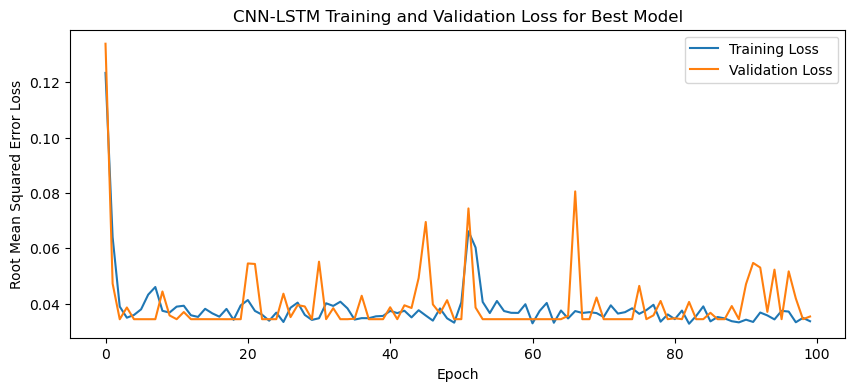

1/1 - 1s - loss: 0.0257 - 1s/epoch - 1s/step
Test Loss: 0.02573494240641594
1/1 [==============================] - 0s 30ms/step


NameError: name 'series' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

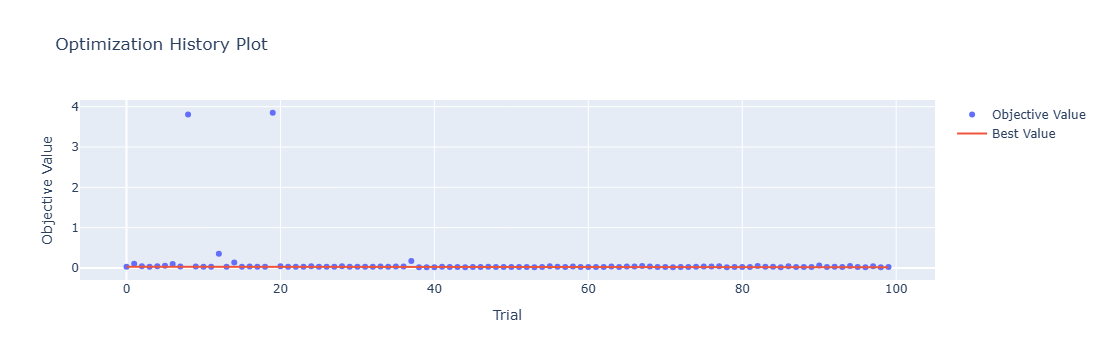

In [4]:
optuna.visualization.plot_optimization_history(study)

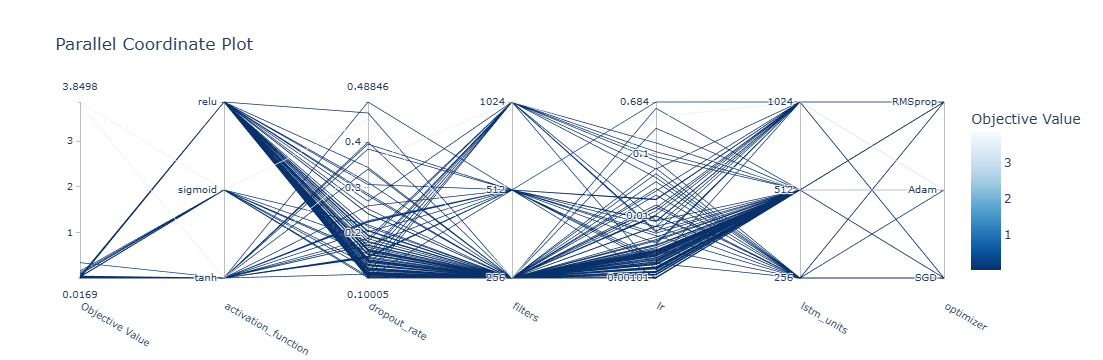

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

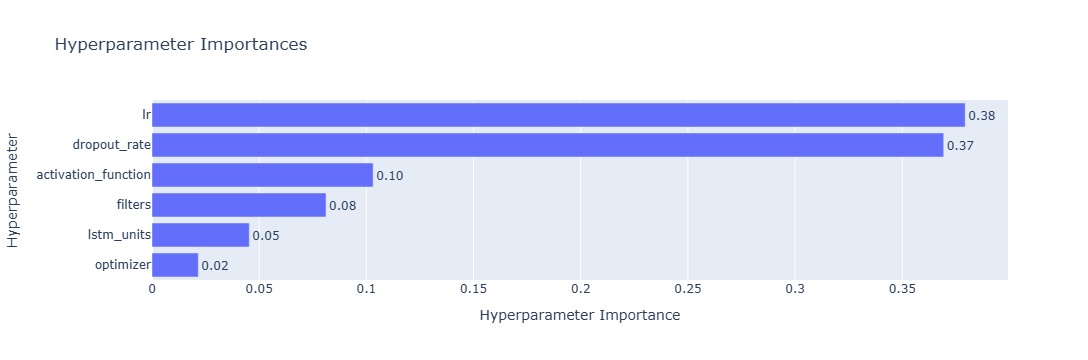

In [6]:
optuna.visualization.plot_param_importances(study)

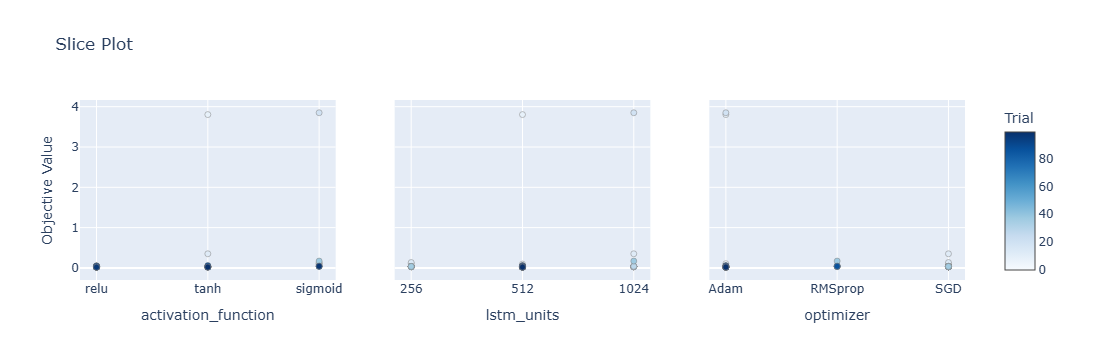

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

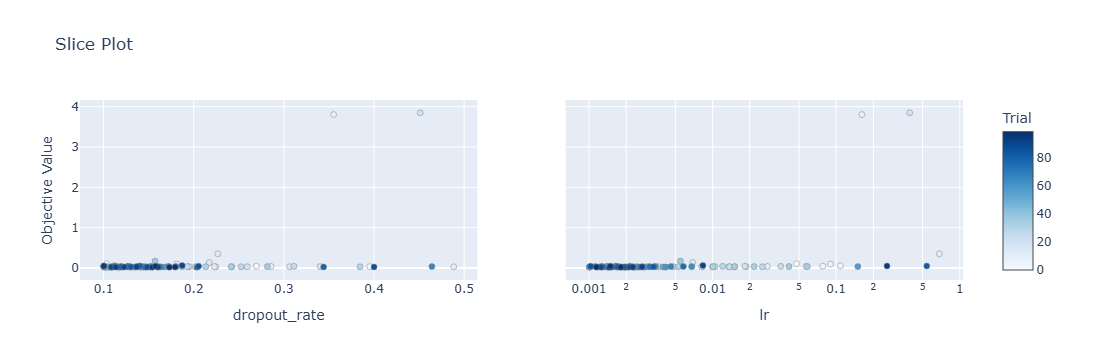

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.21  8.17 15.68 ... 23.86 20.59 15.82]
 [14.52 12.85 16.77 ... 26.49 23.17 21.15]
 [ 8.91  6.23 11.39 ... 22.62 16.72 14.05]
 ...
 [ 7.87  5.76 10.62 ... 21.07 15.24 12.04]
 [ 6.49  2.73  9.77 ... 21.93 16.5  11.44]
 [ 5.29  1.27  5.84 ... 22.11 15.37  9.87]]
Epoch 1/100
84/84 [==============================] - 29s 127ms/step - loss: 0.1285 - accuracy: 0.0000e+00 - mae: 0.1285 - rmse: 0.1285 - mape: 26.7890 - pearson: nan - val_loss: 0.1664 - val_accuracy: 0.0000e+00 - val_mae: 0.1664 - val_rmse: 0.1664 - val_mape: 37.0814 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 5s 56ms/step - loss: 0.0506 - accuracy: 0.0000e+00 - mae: 0.0506 - rmse: 0.0506 - mape: 10.6736 - pearson: nan - val_loss: 0.0782 - val_accuracy: 0.0000e+00 - val_mae: 0.0782 - val_rmse: 0.0782 - val_mape: 17.7726 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 4s 51ms/step - loss: 0.0410 - accuracy: 0.0000e+00 - mae: 0.0410 - rmse: 0.0410 - mape: 8.6330 - pearson: nan

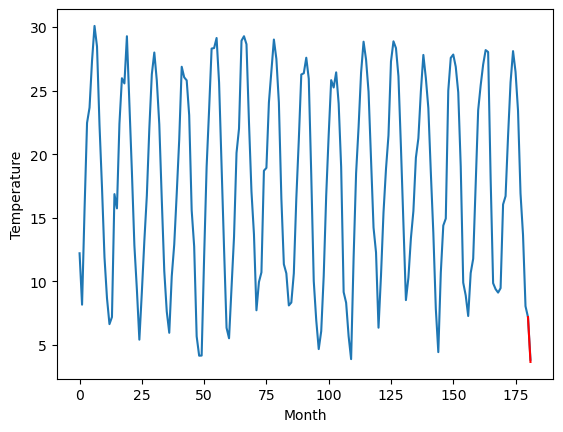

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.87		10.59		-2.28
[180, 181]
[13.23, 10.590736470222474]


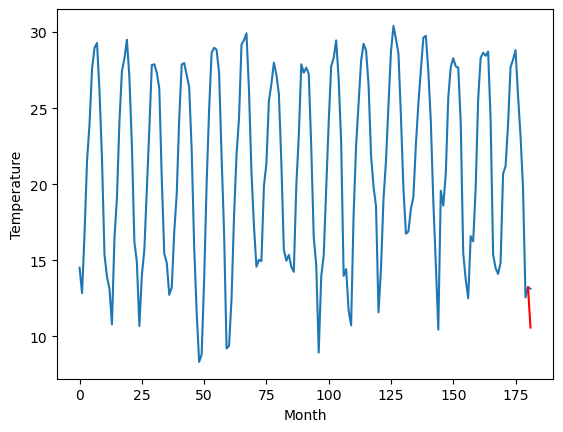

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.34		12.90		-2.44
[180, 181]
[7.18, 12.90073742389679]


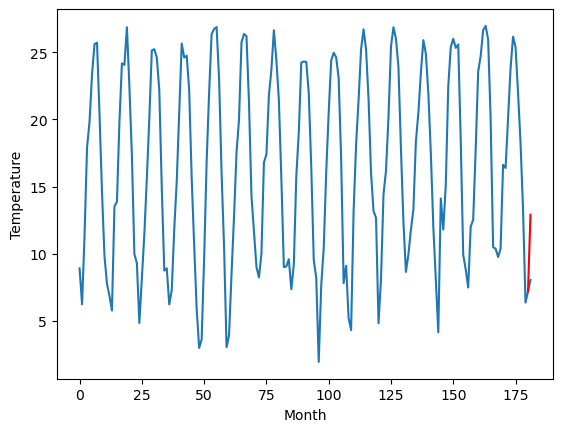

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.00		7.29		-1.71
[180, 181]
[11.46, 7.290738377571106]


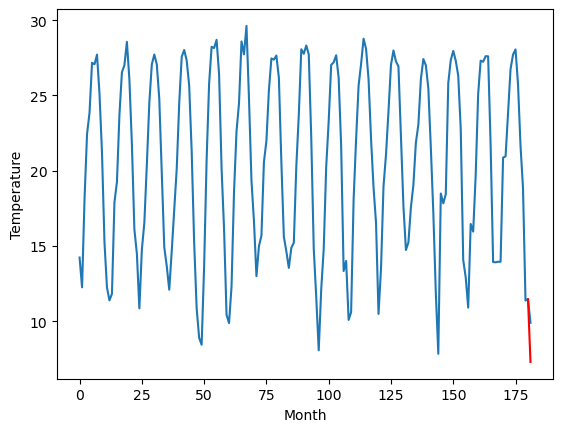

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		12.61		-0.74
[180, 181]
[9.27, 12.610736470222474]


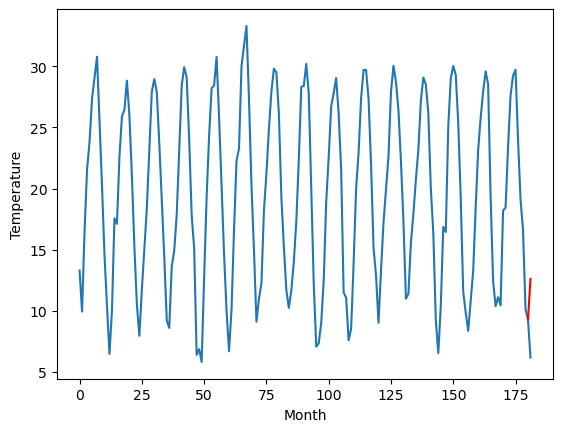

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.52		11.68		0.16
[180, 181]
[7.77, 11.68073742389679]


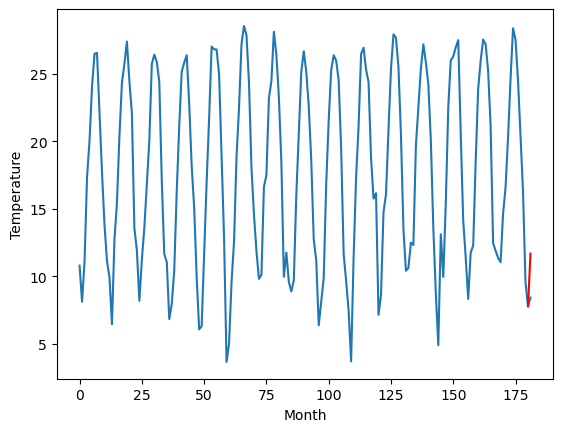

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.21		9.17		-1.04
[180, 181]
[6.59, 9.170737423896789]


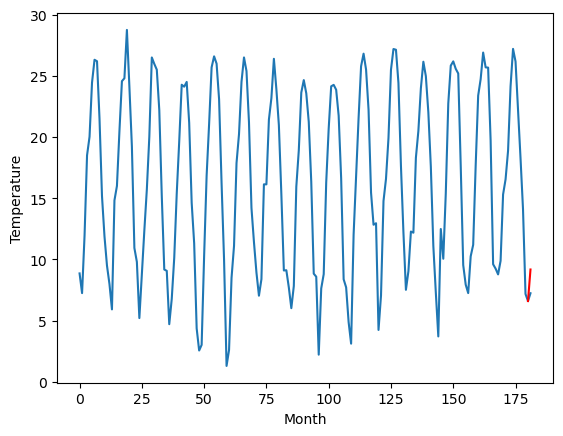

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.91		7.23		-0.68
[180, 181]
[5.3, 7.230737423896789]


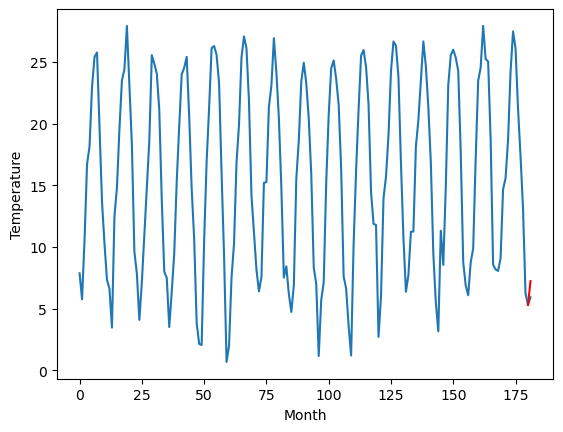

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.08		6.25		-0.83
[180, 181]
[3.1, 6.250736470222473]


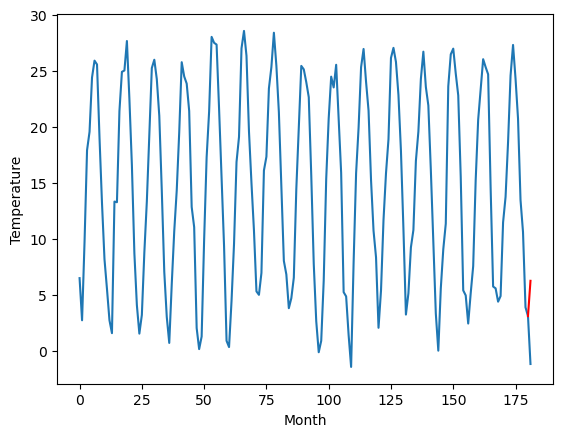

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.90		4.87		-0.03
[180, 181]
[0.6, 4.87073742389679]


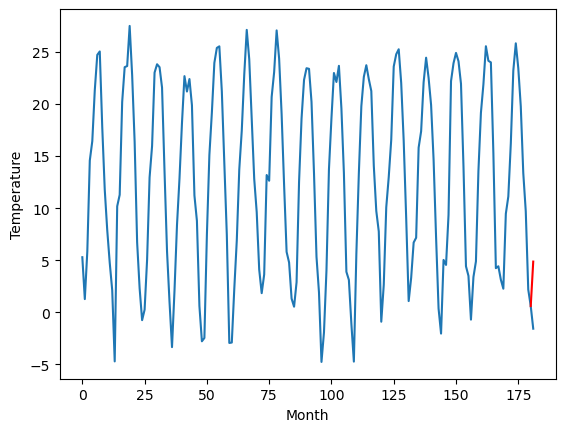

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.68		3.67		-0.01
[180, 181]
[-0.75, 3.670736470222473]


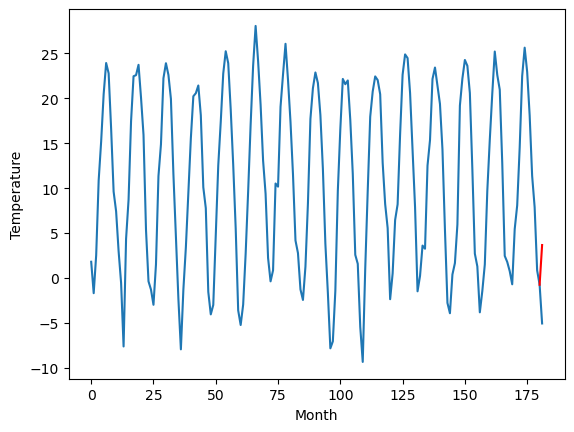

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.43   3.670736
1                 1   12.87  10.590736
2                 2   15.34  12.900737
3                 3    9.00   7.290738
4                 4   13.35  12.610736
5                 5   11.52  11.680737
6                 6   10.21   9.170737
7                 7    7.91   7.230737
8                 8    7.08   6.250736
9                 9    4.90   4.870737
10               10    3.68   3.670736


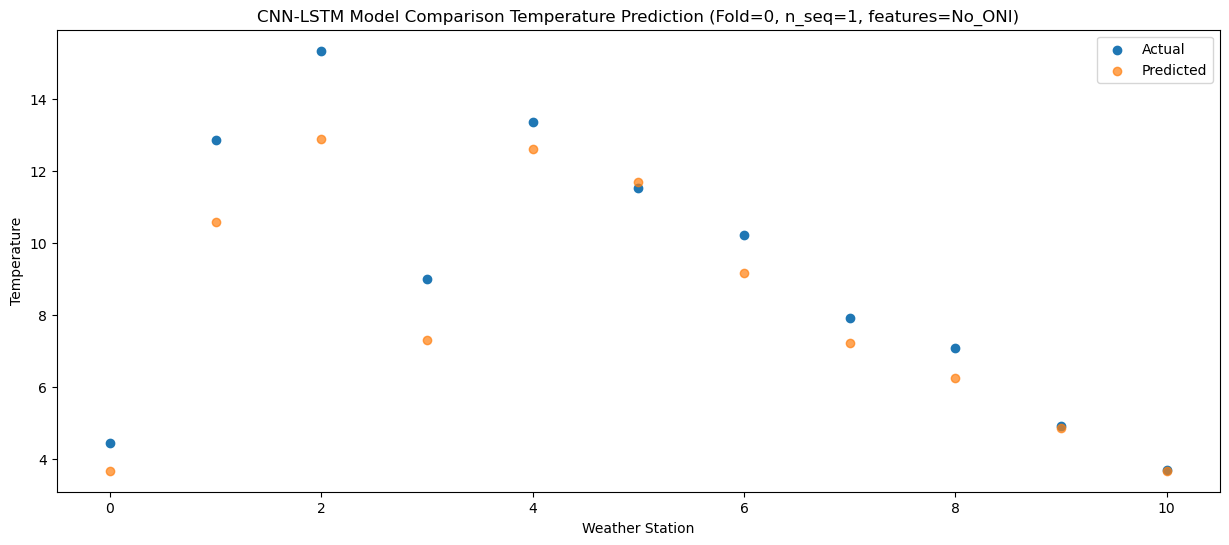

f, t:
[[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68]]
[[ 3.67073647 10.59073647 12.90073742  7.29073838 12.61073647 11.68073742
   9.17073742  7.23073742  6.25073647  4.87073742  3.67073647]]
Year at t+1:
t+1 SKRMSE: 1.259348
t+1 KRMSE: 1.259348
t+1 MAE: 0.970306
t+1 SKMAPE: 0.098184
t+1 R2_SCORE: 0.885701
t+1 KMAPE: 0.098184
t+1 PEARSON: 0.959594
t+1 AVERAGE ACTUAL: 9.117273
Metrics for this Fold:
SKRMSE: 1.259348
KRMSE: 1.259348
MAE: 0.970306
SKMAPE: 0.098184
R2_SCORE: 0.885701
KMAPE: 0.098184
PEARSON: 0.959594
AVERAGE ACTUAL: 9.117273
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 256)            504320    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 256)           0         
 )                                                               
                  

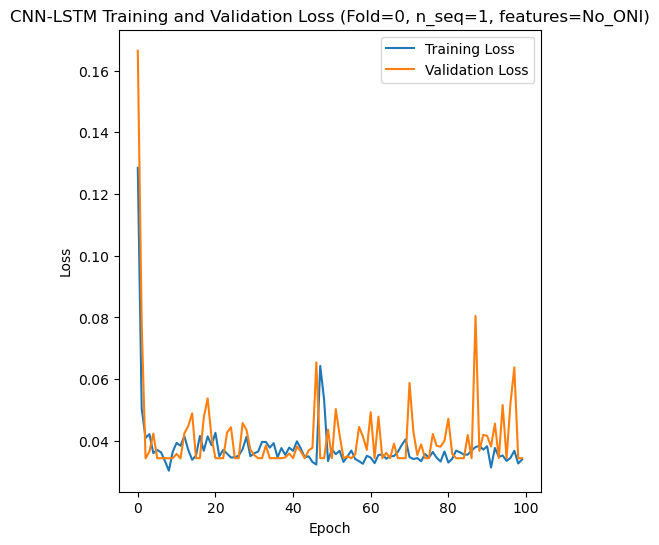

[[12.2  10.03 13.86 ... 24.46 19.58 17.03]
 [ 8.35  6.22 11.74 ... 22.47 18.02 13.98]
 [10.82  7.37 13.36 ... 24.57 19.57 16.15]
 ...
 [ 7.69  4.56 11.66 ... 25.3  19.83 13.28]
 [ 8.93  6.7  14.14 ... 25.37 21.51 12.55]
 [ 7.96  5.46 11.14 ... 25.13 20.28 10.63]]
Epoch 1/100
84/84 [==============================] - 29s 135ms/step - loss: 0.1393 - accuracy: 0.0000e+00 - mae: 0.1393 - rmse: 0.1393 - mape: 29.3924 - pearson: nan - val_loss: 0.0343 - val_accuracy: 0.0000e+00 - val_mae: 0.0343 - val_rmse: 0.0343 - val_mape: 6.9854 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 6s 77ms/step - loss: 0.0764 - accuracy: 0.0000e+00 - mae: 0.0764 - rmse: 0.0764 - mape: 16.3315 - pearson: nan - val_loss: 0.0267 - val_accuracy: 0.0000e+00 - val_mae: 0.0267 - val_rmse: 0.0267 - val_mape: 5.8108 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 5s 59ms/step - loss: 0.0365 - accuracy: 0.0000e+00 - mae: 0.0365 - rmse: 0.0365 - mape: 7.8165 - pearson: nan -

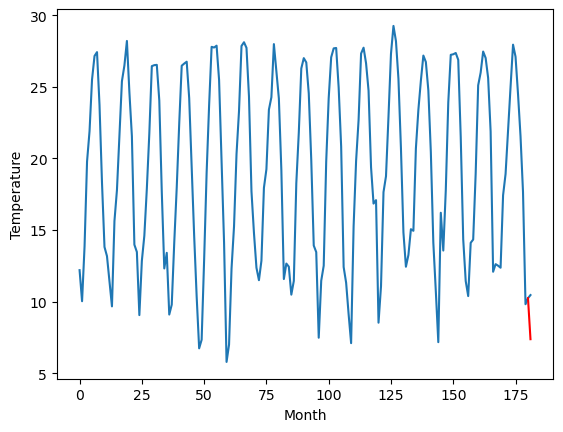

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.00		11.62		-0.38
[180, 181]
[6.41, 11.618133318424224]


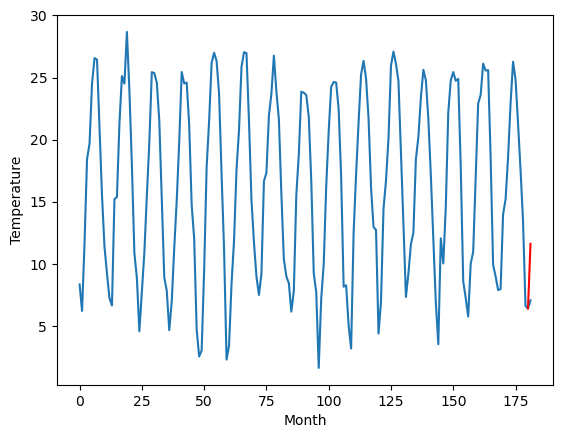

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.77		7.77		-1.00
[180, 181]
[7.6, 7.7681333184242245]


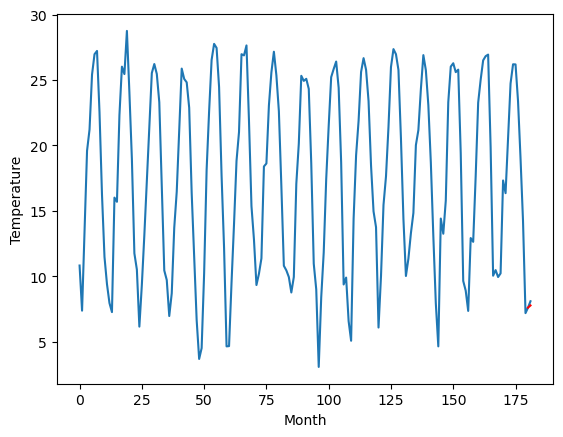

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.72		10.24		-0.48
[180, 181]
[11.89, 10.238133318424225]


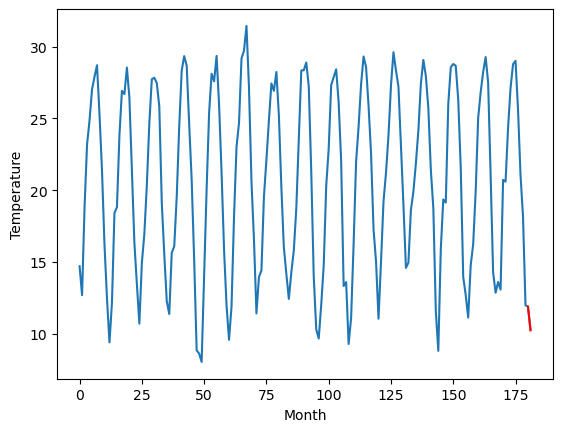

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.70		14.13		-0.57
[180, 181]
[10.96, 14.128133318424226]


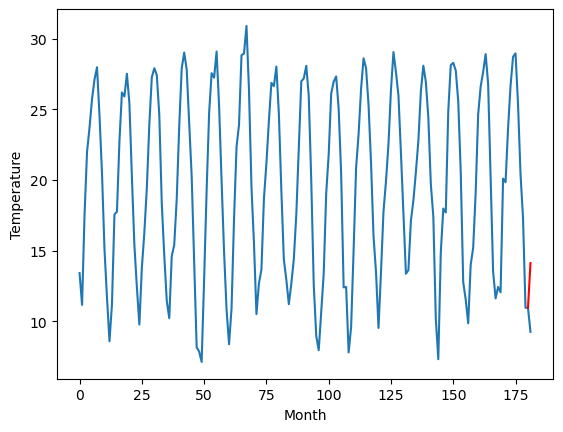

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.91		12.84		0.93
[180, 181]
[7.75, 12.838133318424225]


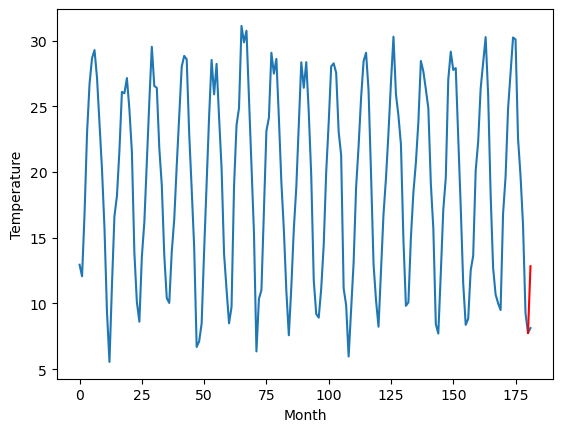

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.75		12.37		-0.38
[180, 181]
[6.17, 12.368133318424224]


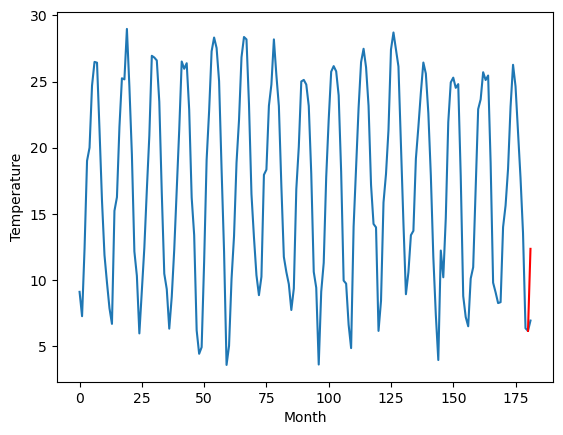

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.81		8.54		-0.27
[180, 181]
[4.57, 8.538131351470946]


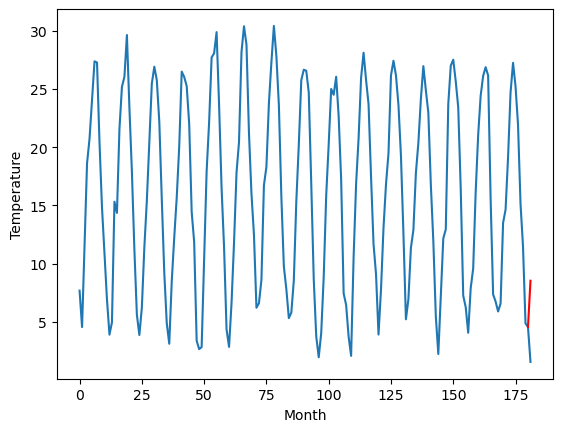

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.34		7.11		-0.23
[180, 181]
[5.46, 7.108133318424225]


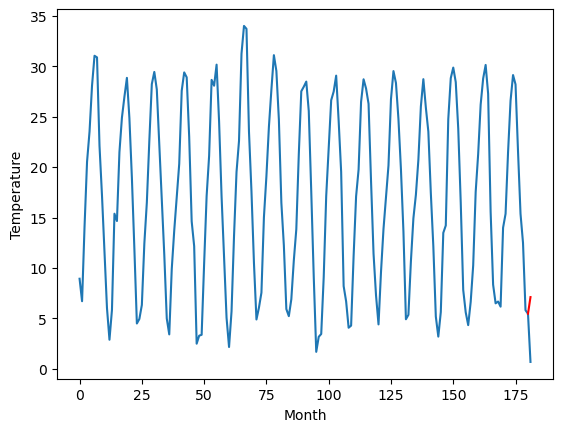

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.04		8.35		-0.69
[180, 181]
[5.42, 8.348133318424225]


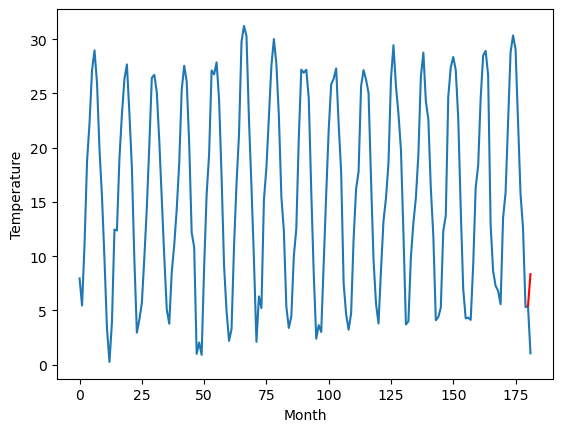

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.12		7.38		1.26
[180, 181]
[2.17, 7.378133318424225]


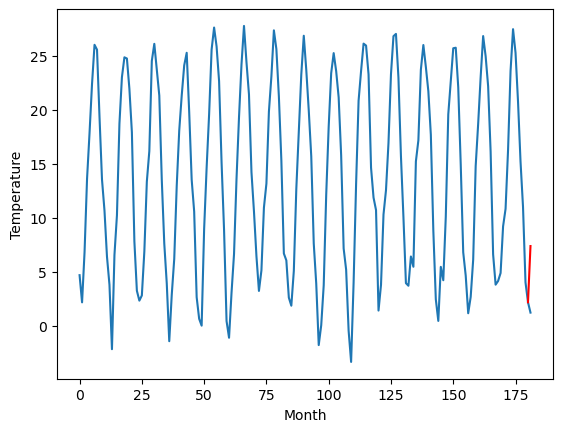

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.38   7.378133
1                 1   12.00  11.618133
2                 2    8.77   7.768133
3                 3   10.72  10.238133
4                 4   14.70  14.128133
5                 5   11.91  12.838133
6                 6   12.75  12.368133
7                 7    8.81   8.538131
8                 8    7.34   7.108133
9                 9    9.04   8.348133
10               10    6.12   7.378133


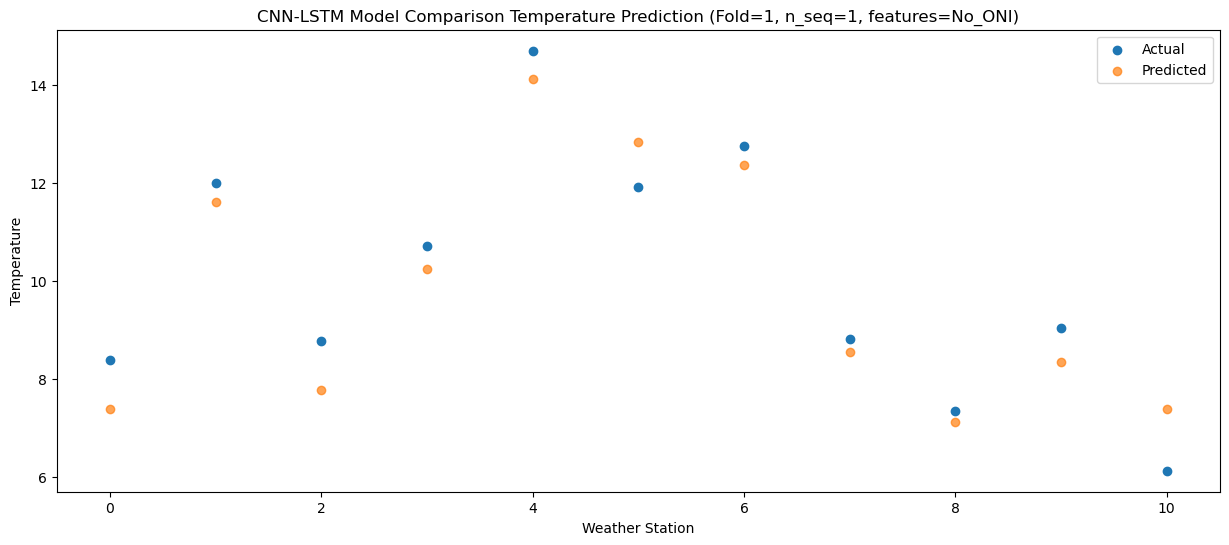

f, t:
[[ 8.38 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12]]
[[ 7.37813332 11.61813332  7.76813332 10.23813332 14.12813332 12.83813332
  12.36813332  8.53813135  7.10813332  8.34813332  7.37813332]]
Year at t+1:
t+1 SKRMSE: 0.732929
t+1 KRMSE: 0.732929
t+1 MAE: 0.654824
t+1 SKMAPE: 0.072901
t+1 R2_SCORE: 0.911005
t+1 KMAPE: 0.072901
t+1 PEARSON: 0.922746
t+1 AVERAGE ACTUAL: 10.049091
Metrics for this Fold:
SKRMSE: 0.732929
KRMSE: 0.732929
MAE: 0.654824
SKMAPE: 0.072901
R2_SCORE: 0.911005
KMAPE: 0.072901
PEARSON: 0.922746
AVERAGE ACTUAL: 10.049091
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 256)            504320    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
              

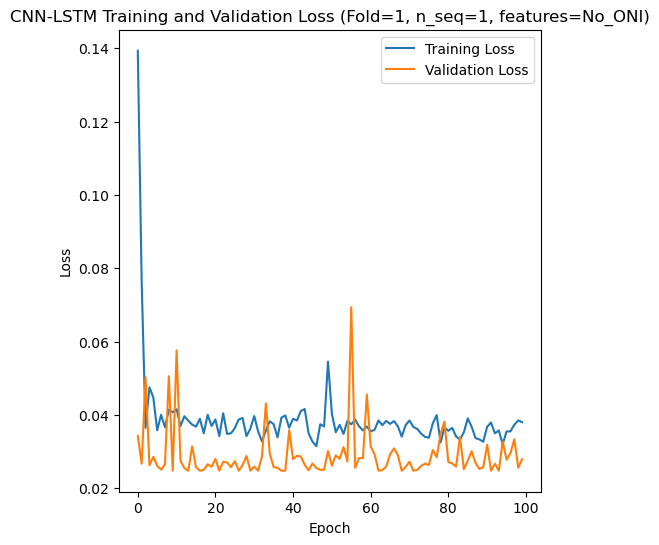

[[ 8.61  4.71 12.22 ... 22.49 18.22 13.52]
 [ 6.28  3.18  8.73 ... 22.36 17.39  7.52]
 [17.82 16.52 20.35 ... 28.79 25.32 22.93]
 ...
 [ 6.77  9.55 12.16 ... 24.55 20.29 10.24]
 [12.04 12.81 10.78 ... 23.32 20.33 13.93]
 [ 8.57  6.56 11.36 ... 21.36 16.14 12.65]]
Epoch 1/100
84/84 [==============================] - 48s 253ms/step - loss: 0.1337 - accuracy: 0.0000e+00 - mae: 0.1337 - rmse: 0.1337 - mape: 28.0643 - pearson: nan - val_loss: 0.0144 - val_accuracy: 0.0000e+00 - val_mae: 0.0144 - val_rmse: 0.0144 - val_mape: 3.2605 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 16s 194ms/step - loss: 0.0604 - accuracy: 0.0000e+00 - mae: 0.0604 - rmse: 0.0604 - mape: 12.6987 - pearson: nan - val_loss: 0.0197 - val_accuracy: 0.0000e+00 - val_mae: 0.0197 - val_rmse: 0.0197 - val_mape: 4.3324 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 15s 180ms/step - loss: 0.0397 - accuracy: 0.0000e+00 - mae: 0.0397 - rmse: 0.0397 - mape: 8.3575 - pearson: n

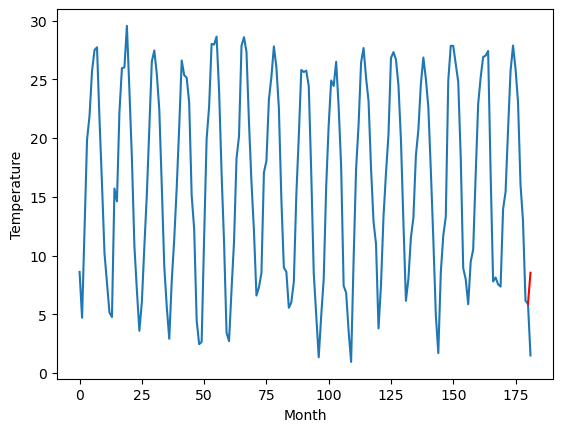

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		8.58		0.05
[180, 181]
[2.63, 8.579735346734523]


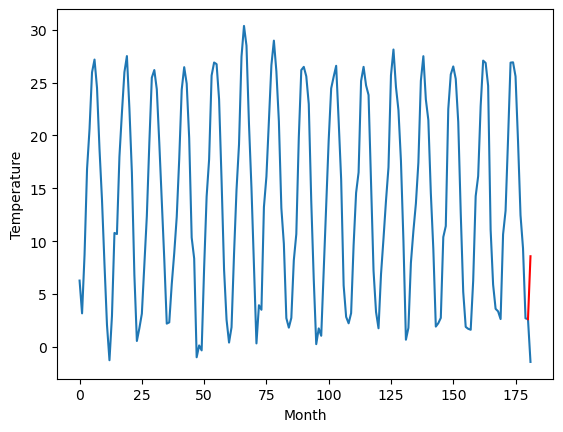

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.94		6.25		-0.69
[180, 181]
[16.55, 6.249735346734524]


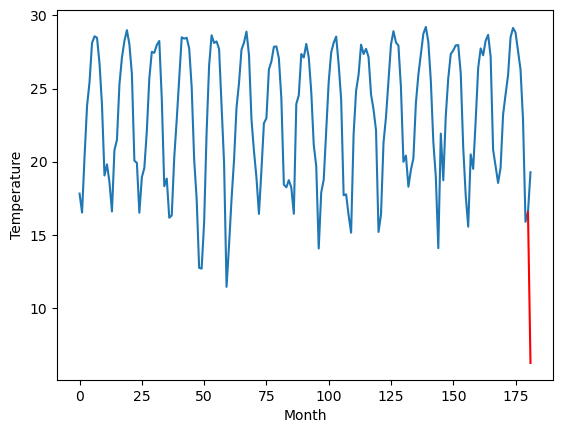

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.74		17.79		3.05
[180, 181]
[-0.83, 17.789735346734524]


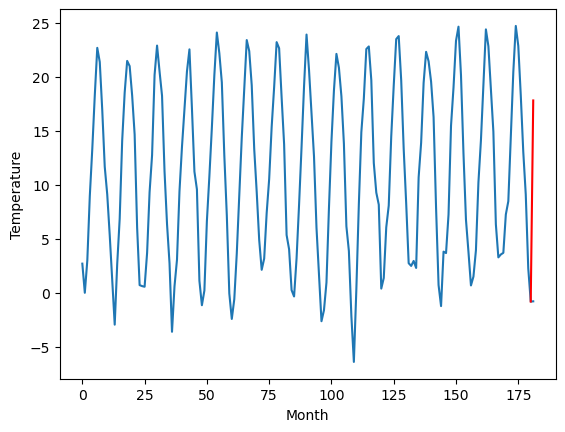

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.03		2.65		-0.38
[180, 181]
[11.52, 2.649735346734524]


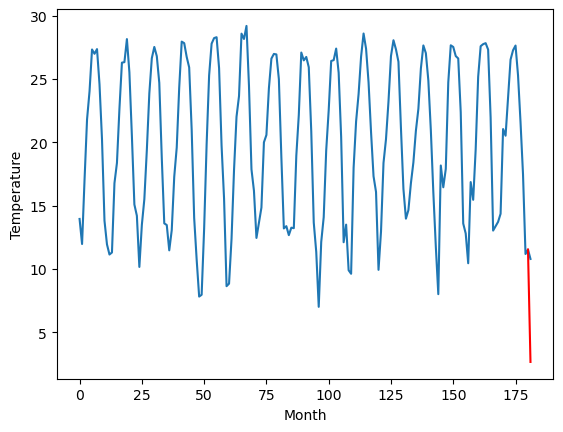

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		13.91		0.56
[180, 181]
[11.47, 13.909735346734523]


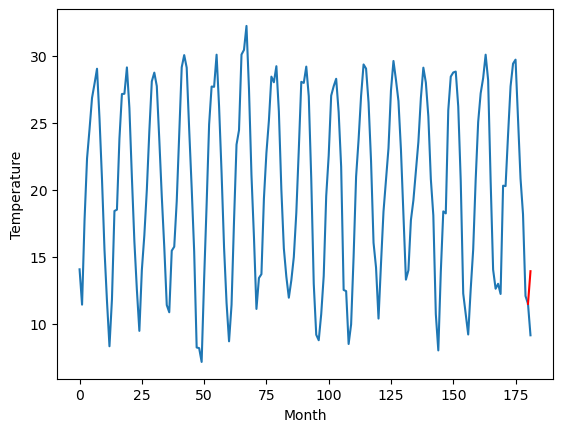

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		14.02		0.67
[180, 181]
[7.75, 14.019735346734524]


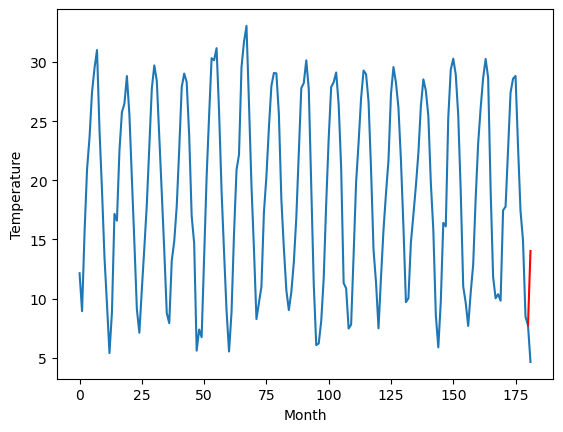

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.68		12.11		-0.57
[180, 181]
[4.9, 12.109735346734524]


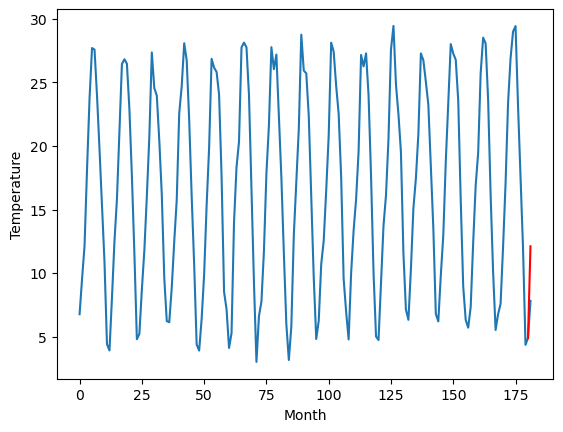

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.71		6.74		0.03
[180, 181]
[14.14, 6.739735346734523]


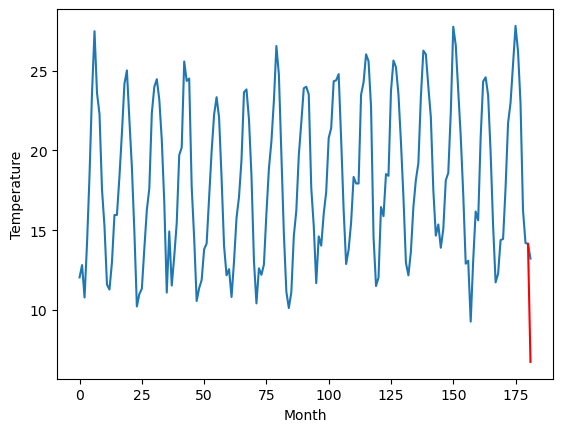

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.63		12.01		0.38
[180, 181]
[5.55, 12.009735346734523]


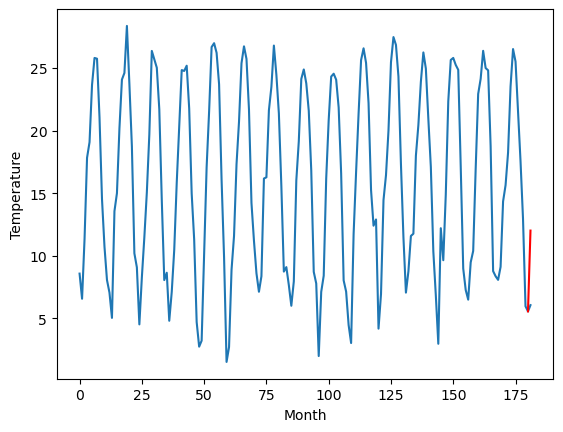

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.90		8.54		-0.36
[180, 181]
[3.19, 8.539735346734524]


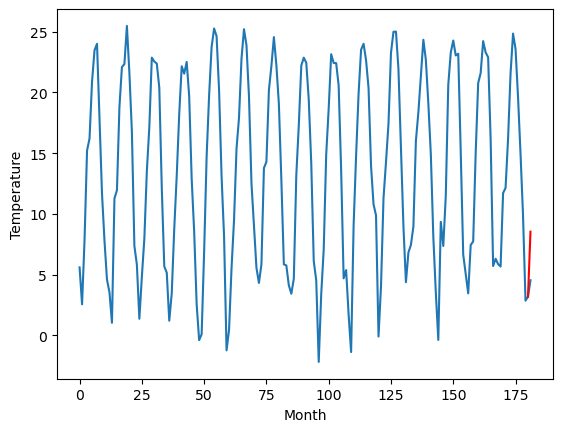

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.31   8.539735
1                 1    8.53   8.579735
2                 2    6.94   6.249735
3                 3   14.74  17.789735
4                 4    3.03   2.649735
5                 5   13.35  13.909735
6                 6   13.35  14.019735
7                 7   12.68  12.109735
8                 8    6.71   6.739735
9                 9   11.63  12.009735
10               10    8.90   8.539735


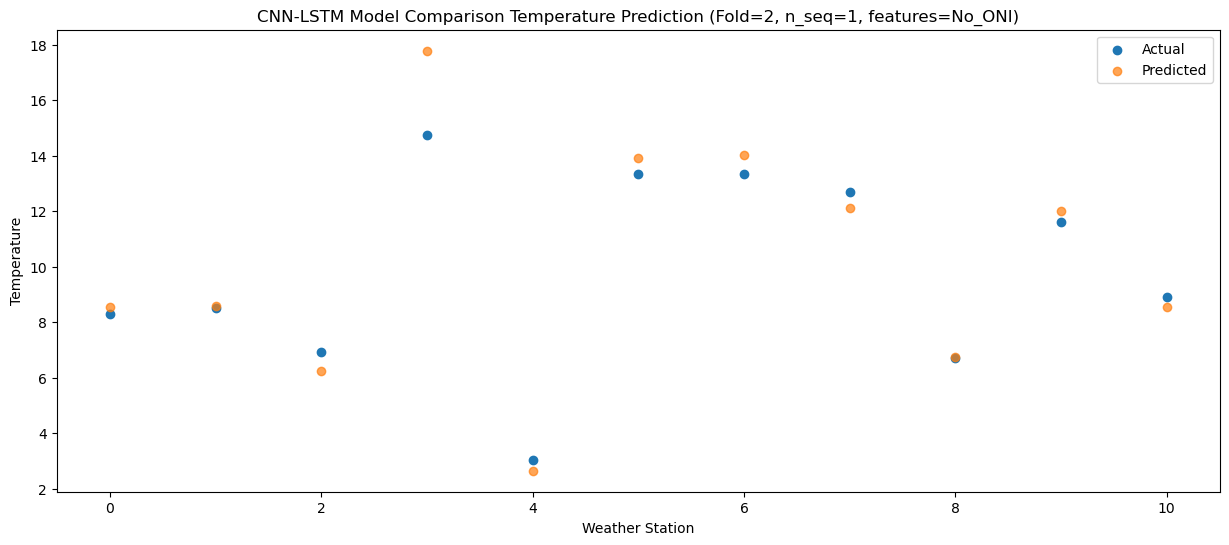

f, t:
[[ 8.31  8.53  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9 ]]
[[ 8.53973535  8.57973535  6.24973535 17.78973535  2.64973535 13.90973535
  14.01973535 12.10973535  6.73973535 12.00973535  8.53973535]]
Year at t+1:
t+1 SKRMSE: 1.015298
t+1 KRMSE: 1.015298
t+1 MAE: 0.633564
t+1 SKMAPE: 0.061816
t+1 R2_SCORE: 0.912401
t+1 KMAPE: 0.061816
t+1 PEARSON: 0.964758
t+1 AVERAGE ACTUAL: 9.833636
Metrics for this Fold:
SKRMSE: 1.015298
KRMSE: 1.015298
MAE: 0.633564
SKMAPE: 0.061816
R2_SCORE: 0.912401
KMAPE: 0.061816
PEARSON: 0.964758
AVERAGE ACTUAL: 9.833636
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 256)            504320    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                

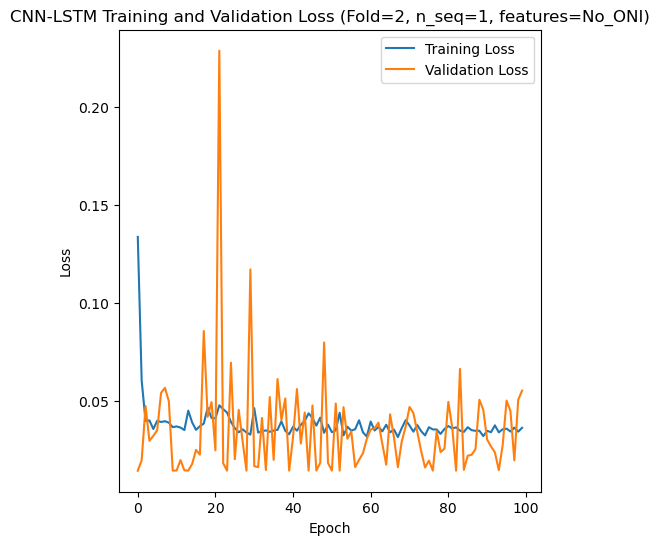

[[ 8.9   6.89 11.3  ... 22.19 16.88 13.54]
 [ 7.02  3.15 10.24 ... 22.31 18.92 11.32]
 [ 7.65  9.7   9.44 ... 25.68 20.65 11.46]
 ...
 [ 9.57 11.93 12.22 ... 30.9  25.01 12.37]
 [ 9.04  9.3   8.59 ... 17.72 17.26 10.73]
 [ 3.2   0.4   3.78 ... 18.92 14.39 10.04]]
Epoch 1/100
84/84 [==============================] - 51s 257ms/step - loss: 0.1425 - accuracy: 0.0000e+00 - mae: 0.1425 - rmse: 0.1425 - mape: 32.1333 - pearson: nan - val_loss: 0.0439 - val_accuracy: 0.0000e+00 - val_mae: 0.0439 - val_rmse: 0.0439 - val_mape: 9.4401 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 15s 175ms/step - loss: 0.0489 - accuracy: 0.0000e+00 - mae: 0.0489 - rmse: 0.0489 - mape: 11.0989 - pearson: nan - val_loss: 0.0372 - val_accuracy: 0.0000e+00 - val_mae: 0.0372 - val_rmse: 0.0372 - val_mape: 7.3816 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 15s 175ms/step - loss: 0.0414 - accuracy: 0.0000e+00 - mae: 0.0414 - rmse: 0.0414 - mape: 9.3758 - pearson: n

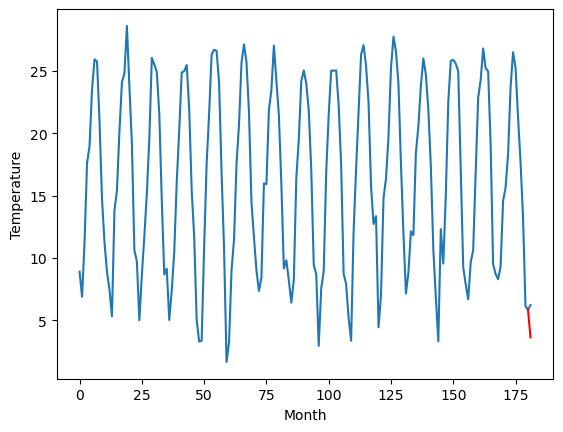

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.75		9.33		1.58
[180, 181]
[3.2, 9.32826607823372]


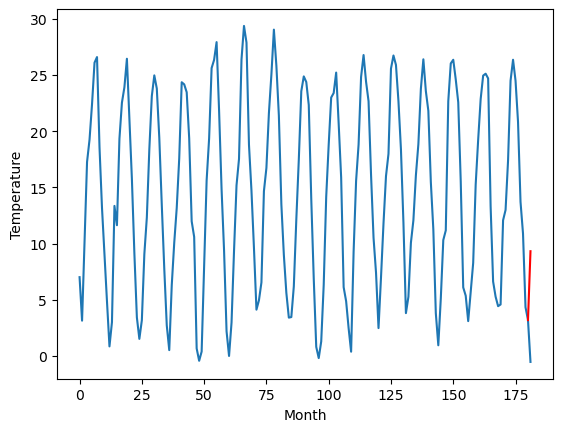

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.28		7.45		-0.83
[180, 181]
[8.48, 7.448344368934631]


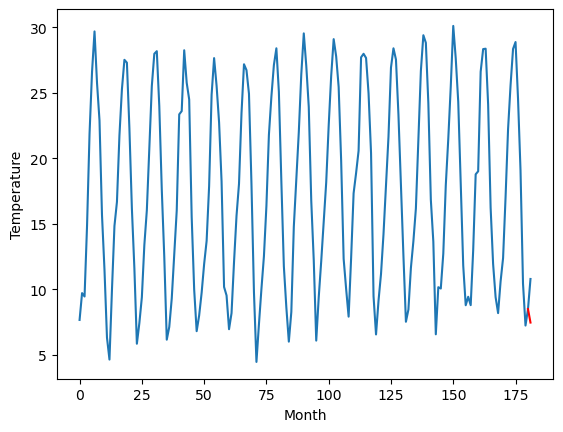

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.19		8.08		1.89
[180, 181]
[1.55, 8.078249090909958]


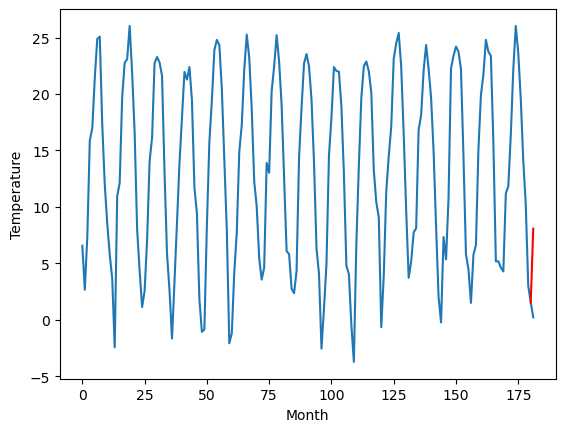

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.10		7.00		1.90
[180, 181]
[1.08, 6.998228318691254]


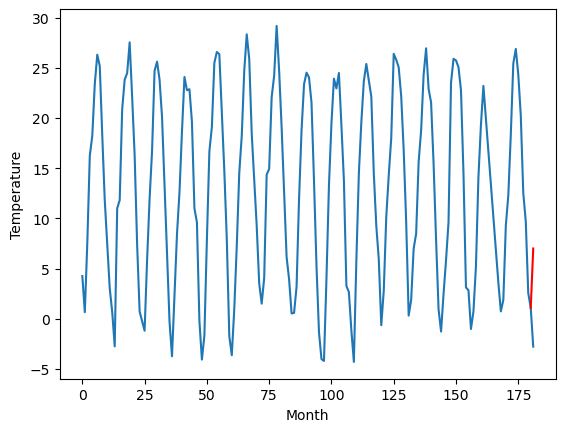

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.80		4.68		1.88
[180, 181]
[0.21, 4.678217947483063]


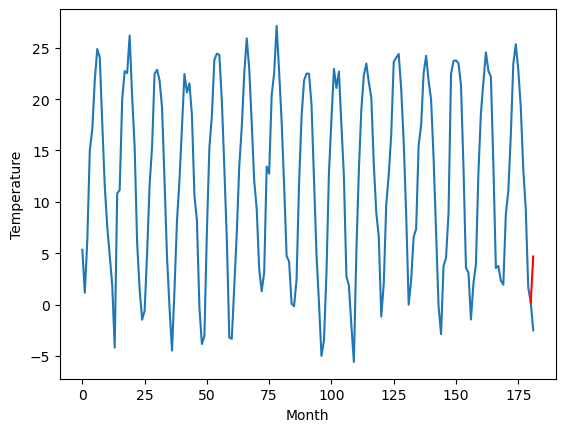

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.60		5.76		0.16
[180, 181]
[-8.22, 5.758324580192566]


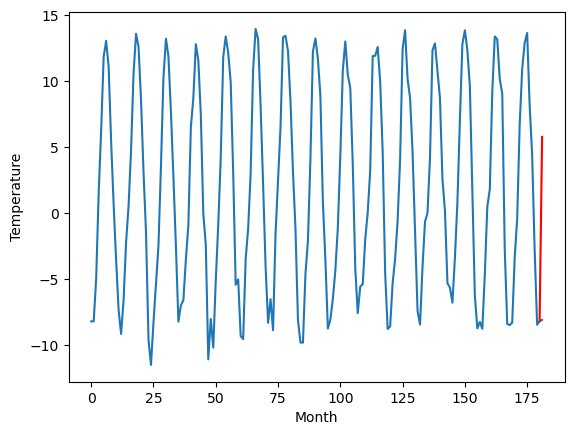

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-7.69		-7.81		-0.12
[180, 181]
[10.04, -7.811652799844742]


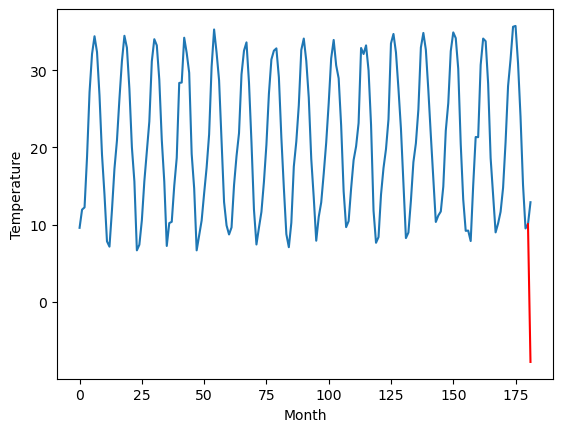

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		10.00		-0.79
[180, 181]
[9.17, 9.998347200155258]


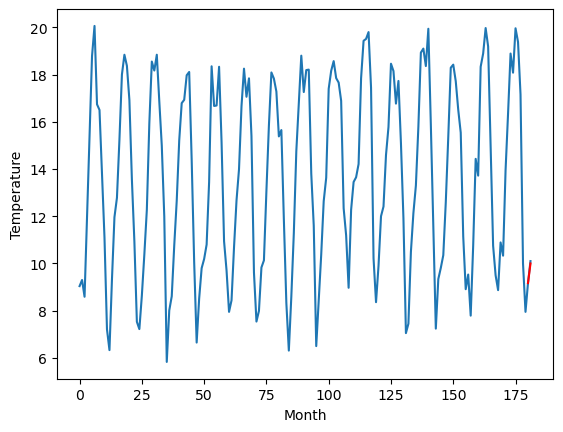

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.02		9.47		3.45
[180, 181]
[0.94, 9.468236812353133]


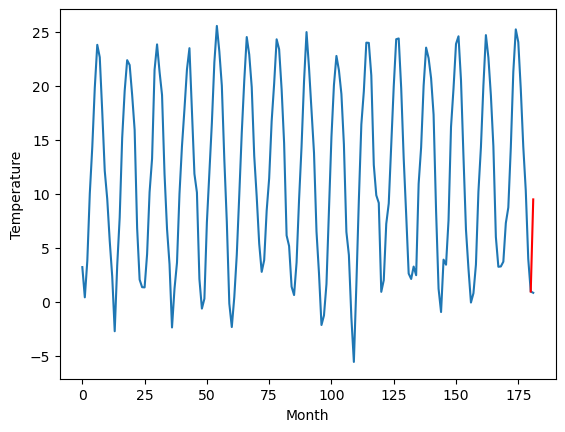

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.64		3.63		1.99
[180, 181]
[-0.13, 3.6282339811325075]


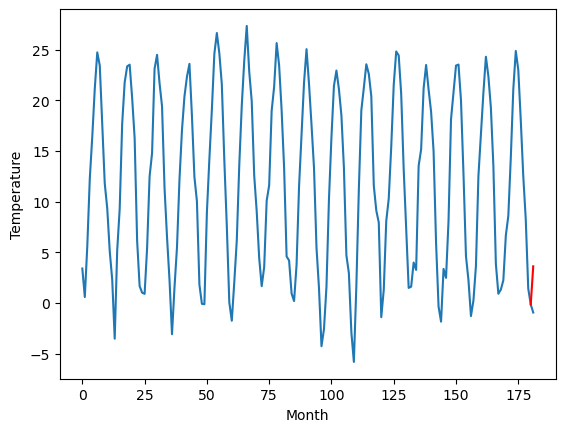

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.92   3.628290
1                 1    7.75   9.328266
2                 2    8.28   7.448344
3                 3    6.19   8.078249
4                 4    5.10   6.998228
5                 5    2.80   4.678218
6                 6    5.60   5.758325
7                 7   -7.69  -7.811653
8                 8   10.79   9.998347
9                 9    6.02   9.468237
10               10    1.64   3.628234


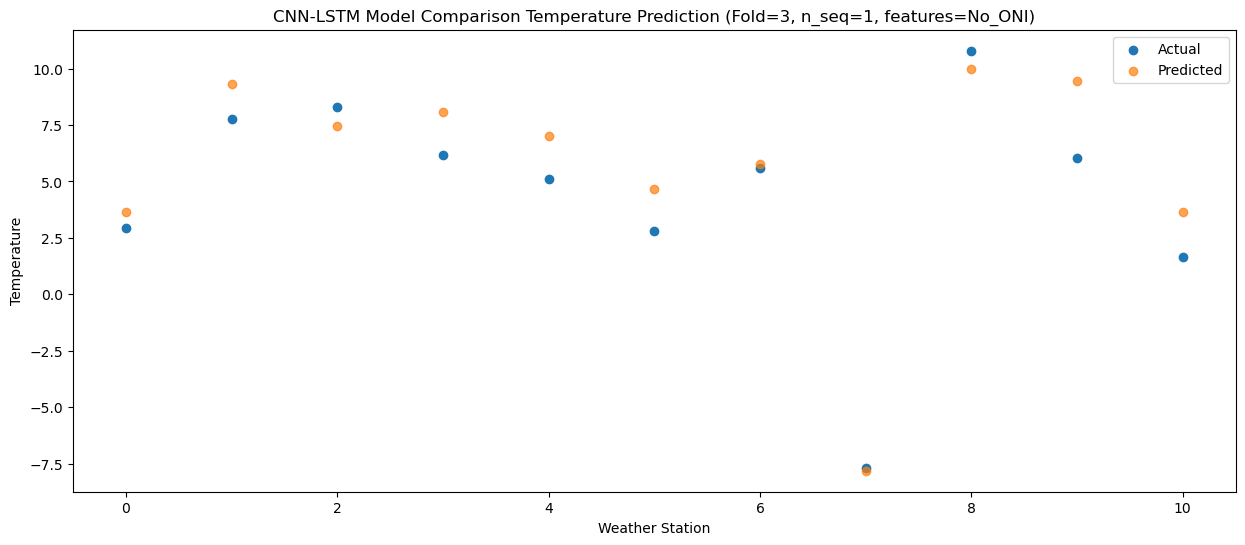

f, t:
[[ 2.92  7.75  8.28  6.19  5.1   2.8   5.6  -7.69 10.79  6.02  1.64]]
[[ 3.62828965  9.32826608  7.44834437  8.07824909  6.99822832  4.67821795
   5.75832458 -7.8116528   9.9983472   9.46823681  3.62823398]]
Year at t+1:
t+1 SKRMSE: 1.675782
t+1 KRMSE: 1.675782
t+1 MAE: 1.390092
t+1 SKMAPE: 0.345208
t+1 R2_SCORE: 0.867600
t+1 KMAPE: 0.342332
t+1 PEARSON: 0.926607
t+1 AVERAGE ACTUAL: 4.490909
Metrics for this Fold:
SKRMSE: 1.675782
KRMSE: 1.675782
MAE: 1.390092
SKMAPE: 0.345208
R2_SCORE: 0.867600
KMAPE: 0.342332
PEARSON: 0.926607
AVERAGE ACTUAL: 4.490909
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 256)            504320    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                

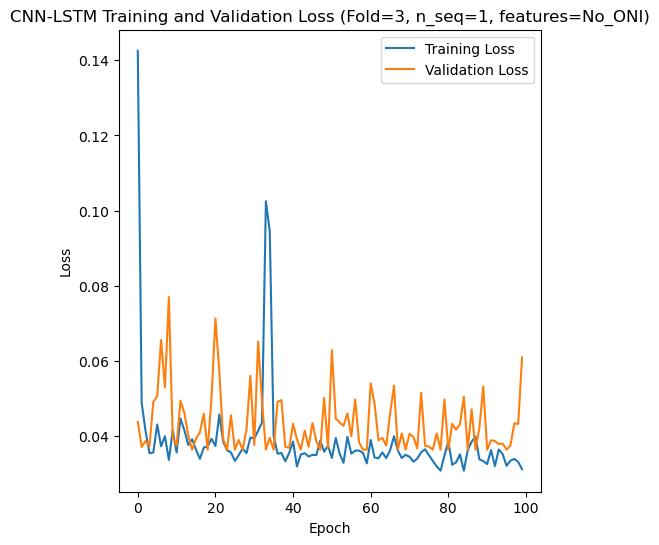

[[ 4.89  1.26  7.78 ... 22.59 18.46  9.82]
 [15.38 13.87 17.63 ... 26.66 22.89 20.2 ]
 [11.49  8.39 14.48 ... 24.97 20.83 17.82]
 ...
 [ 7.64  3.61 10.44 ... 21.3  17.62 11.34]
 [ 4.26  0.29  5.21 ... 21.47 15.54  9.34]
 [ 3.62 -0.32  6.05 ... 19.99 14.92  8.29]]
Epoch 1/100
84/84 [==============================] - 50s 264ms/step - loss: 0.1334 - accuracy: 0.0000e+00 - mae: 0.1334 - rmse: 0.1334 - mape: 28.2761 - pearson: nan - val_loss: 0.0672 - val_accuracy: 0.0000e+00 - val_mae: 0.0672 - val_rmse: 0.0672 - val_mape: 15.7071 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 15s 176ms/step - loss: 0.0675 - accuracy: 0.0000e+00 - mae: 0.0675 - rmse: 0.0675 - mape: 14.3143 - pearson: nan - val_loss: 0.0963 - val_accuracy: 0.0000e+00 - val_mae: 0.0963 - val_rmse: 0.0963 - val_mape: 22.4998 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 14s 171ms/step - loss: 0.0419 - accuracy: 0.0000e+00 - mae: 0.0419 - rmse: 0.0419 - mape: 8.8081 - pearson:

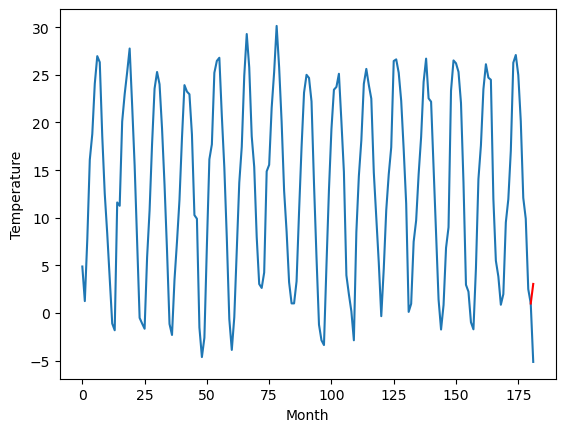

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.59		4.33		-1.26
[180, 181]
[14.25, 4.331856563091278]


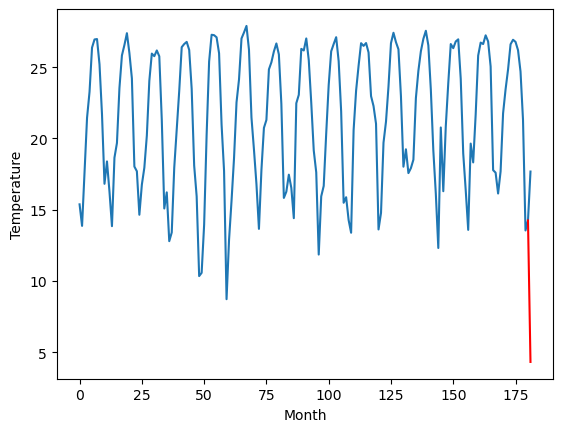

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.41		14.82		-0.59
[180, 181]
[9.06, 14.821863417625428]


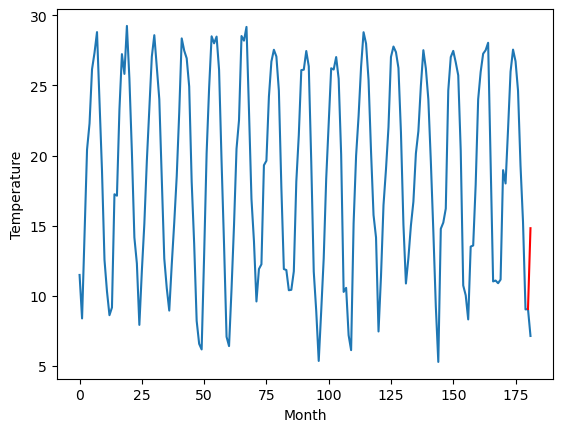

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.57		10.93		0.36
[180, 181]
[7.48, 10.931874206066132]


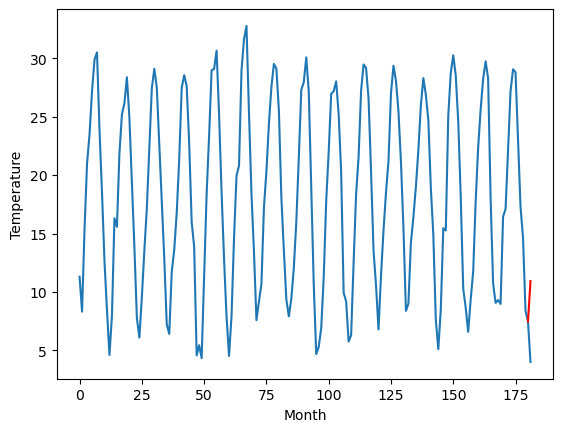

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.71		10.75		0.04
[180, 181]
[7.33, 10.751874206066132]


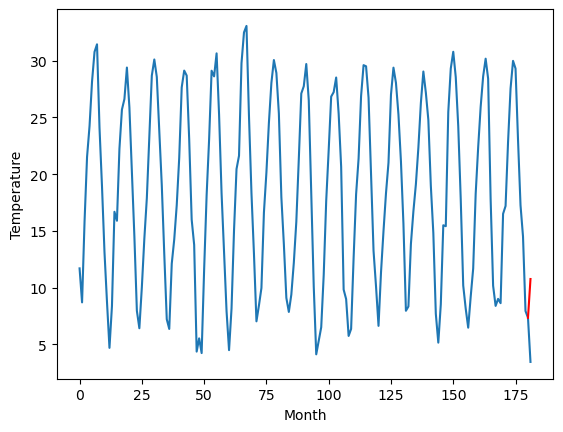

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.59		11.13		0.54
[180, 181]
[6.59, 11.131868364810943]


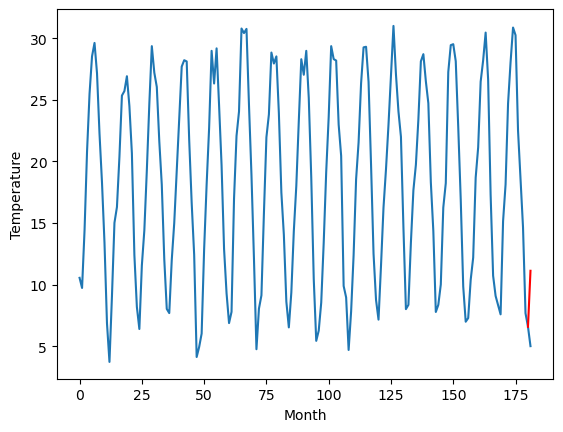

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		10.00		-0.79
[180, 181]
[6.04, 10.001857516765595]


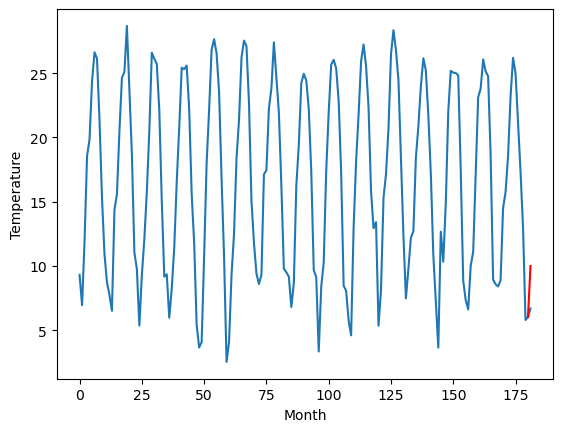

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.65		8.76		1.11
[180, 181]
[3.13, 8.761868364810944]


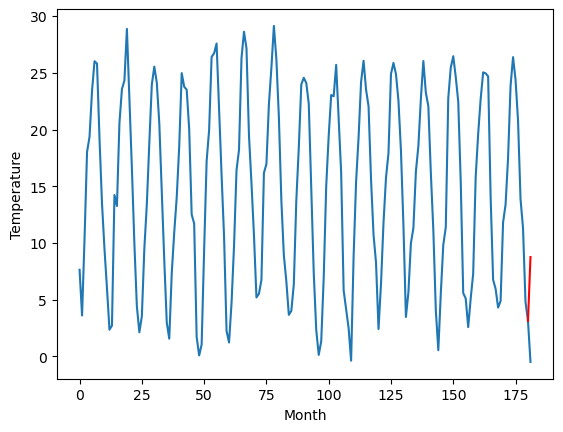

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.06		7.08		1.02
[180, 181]
[-0.29, 7.081868364810943]


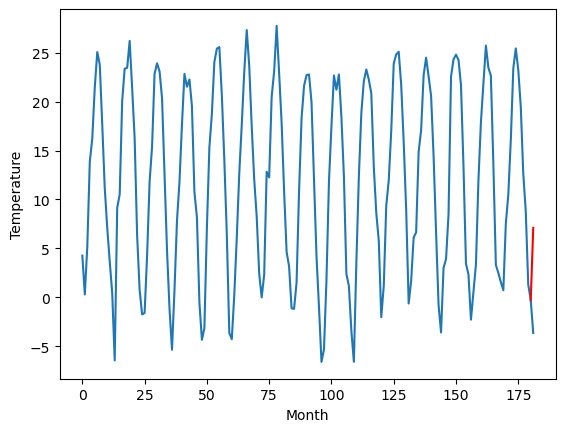

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.23		3.70		1.47
[180, 181]
[-1.03, 3.701872239112854]


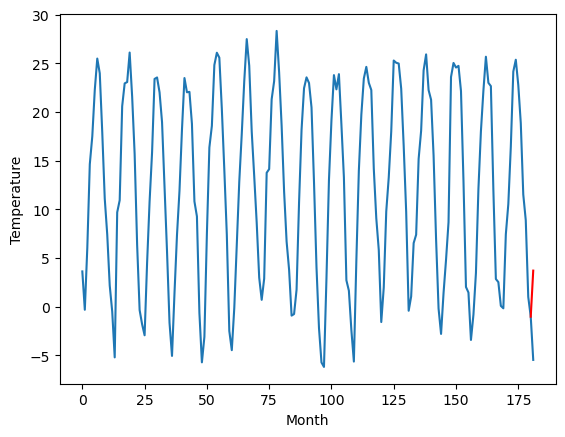

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.70		3.06		1.36
[180, 181]
[-2.29, 3.0618702721595765]


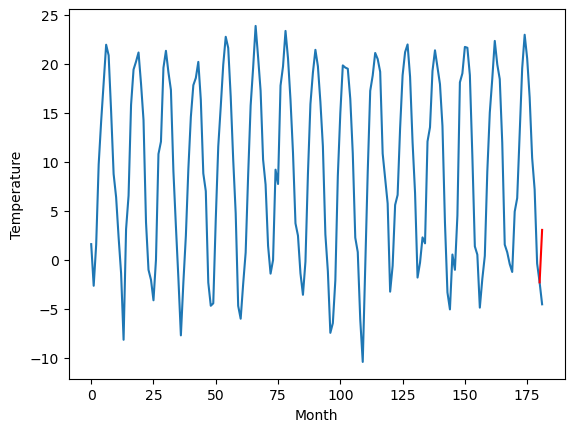

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.11   3.061873
1                 1    5.59   4.331857
2                 2   15.41  14.821863
3                 3   10.57  10.931874
4                 4   10.71  10.751874
5                 5   10.59  11.131868
6                 6   10.79  10.001858
7                 7    7.65   8.761868
8                 8    6.06   7.081868
9                 9    2.23   3.701872
10               10    1.70   3.061870


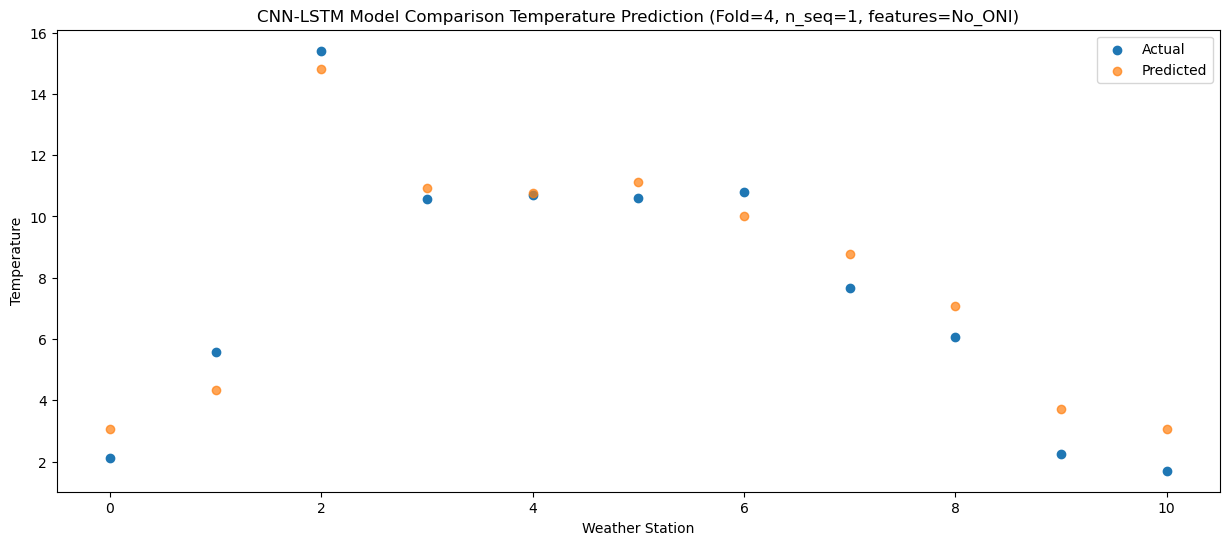

f, t:
[[ 2.11  5.59 15.41 10.57 10.71 10.59 10.79  7.65  6.06  2.23  1.7 ]]
[[ 3.06187325  4.33185656 14.82186342 10.93187421 10.75187421 11.13186836
  10.00185752  8.76186836  7.08186836  3.70187224  3.06187027]]
Year at t+1:
t+1 SKRMSE: 0.962192
t+1 KRMSE: 0.962192
t+1 MAE: 0.863581
t+1 SKMAPE: 0.241074
t+1 R2_SCORE: 0.948774
t+1 KMAPE: 0.241074
t+1 PEARSON: 0.964880
t+1 AVERAGE ACTUAL: 7.582727
Metrics for this Fold:
SKRMSE: 0.962192
KRMSE: 0.962192
MAE: 0.863581
SKMAPE: 0.241074
R2_SCORE: 0.948774
KMAPE: 0.241074
PEARSON: 0.964880
AVERAGE ACTUAL: 7.582727
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 256)            504320    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                

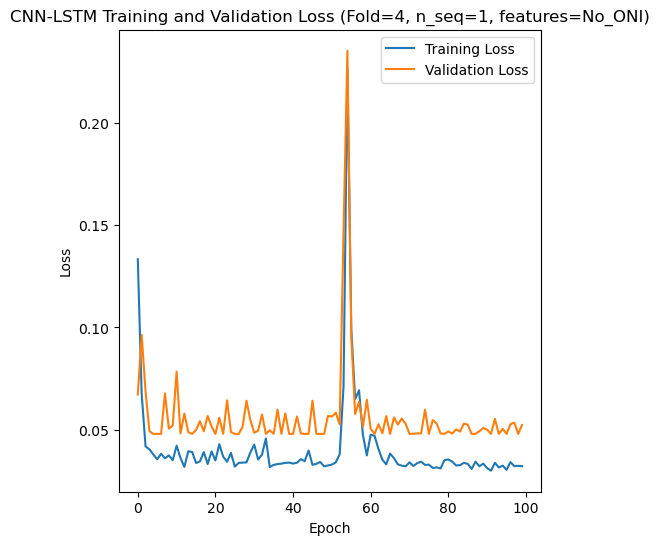

[[1.259348031300917], [0.7329287544105002], [1.0152979289601256], [1.6757820123069516], [0.9621922538437461]]
[[array(1.25934803)], [array(0.73292875)], [array(1.01529793)], [array(1.67578201)], [array(0.96219225)]]
[[0.9703060908751059], [0.6548244307257909], [0.6335641854730514], [1.3900916083292532], [0.863581070249731]]
[[0.09818448302610204], [0.07290058779755385], [0.061815518235862905], [0.34520830382280127], [0.24107441169352428]]
[[0.8857005174265606], [0.9110052191949627], [0.9124006400352973], [0.8675995773735117], [0.9487737001439679]]
[[array(0.09818448)], [array(0.07290059)], [array(0.06181552)], [array(0.34233201)], [array(0.24107441)]]
[[array(0.95959444)], [array(0.92274573)], [array(0.96475756)], [array(0.92660667)], [array(0.96488009)]]
[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68  8.38
 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12  8.31  8.53
  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9   2.92  7.75  8.28
  6.19  5.1   2

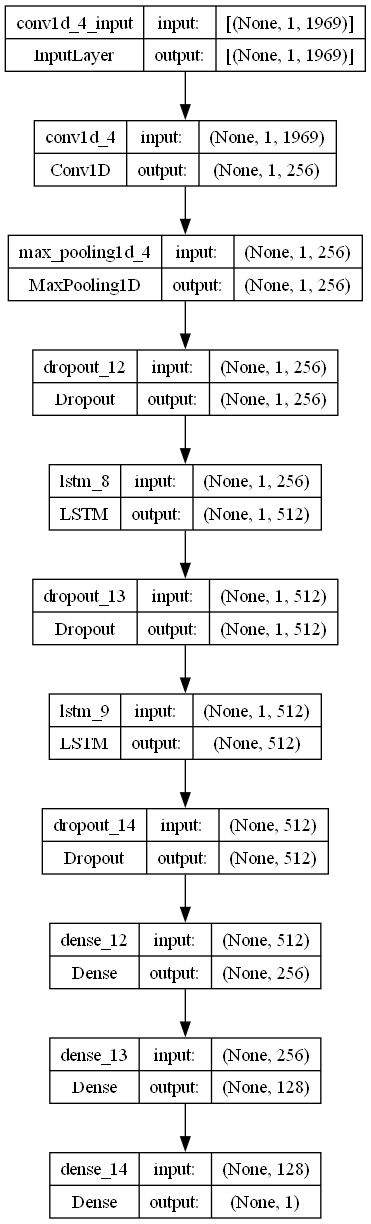

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.0019754704739758187
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.1469991348870498

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))
    
    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S1_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)